# **FGV EESP**

- ## Dados Econômicos - Brasil
---



### **Bibliotecas**

In [84]:
# Obter os dados do SGS do Banco Central do Brasil
install.packages("rbcb")

# Gráficos de sazonalidade
install.packages("forecast")

# Testes de raiz unitária
install.packages("urca")

# Estatística descritiva
install.packages("stargazer")

# Painéis com gráficos
install.packages("gridExtra")

# Modelo VAR
install.packages("vars")

# Modelo VECM
install.packages("tsDyn")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘deSolve’, ‘iterators’, ‘mnormt’, ‘tseriesChaos’, ‘foreach’




In [85]:
library(dplyr)
library(forecast)
library(ggplot2)
library(gridExtra)
library(rbcb)
library(readxl)
library(tidyverse)
library(tsDyn)
library(stargazer)
library(urca)
library(vars)
library(zoo)

### **Dados**

In [3]:
# Indicador de Expectativa de Inflação dos Consumidores
# Código FGV Dados: 1416188

# Caminho do arquivo original
file_path <- "https://github.com/matheusrmorgado/inflation-expectation/raw/main/data/fgv_ibre.xlsx"

# Download do arquivo
download.file(file_path, "fgv_ibre.xlsx")

# Ler o arquivo Excel e converter em dataframe
df_fgv <- as.data.frame(read_excel("fgv_ibre.xlsx"))

# Filtrar os dados de 2006-01-01 até 2023-06-01
df_fgv <- df_fgv %>% filter(as.Date(month_date) >= as.Date("2006-01-01") & as.Date(month_date) <= as.Date("2023-06-01"))

# Conversão em formato timeseries
consumer_inflation_expectation <- as.data.frame(ts(df_fgv$consumer_inflation_expectation, start = c(2006, 1), frequency = 12))
consumer_inflation_expectation <- rename(consumer_inflation_expectation, consumer_inflation_expectation = x)

# Criar um data frame com as séries temporais
df_fgv <- consumer_inflation_expectation
df_fgv$month = time(df_fgv$consumer_inflation_expectation)

In [4]:
# Índice nacional de preços ao consumidor amplo acumulado em 12 meses (%)
# SGS: 13522
ipca <- as.data.frame(get_series(13522, start_date = "2006-01-01", end_date = "2023-06-01", as = "ts"))
ipca <- rename(ipca, ipca = x)

# Taxa de juros Selic acumulada no mês anualizada base 252 (% a.a.)
# SGS: 4189
selic <- as.data.frame(get_series(4189, start_date = "2006-01-01", end_date = "2023-06-01", as = "ts"))
selic <- rename(selic, selic = x)

# Índice de Atividade Econômica do Banco Central com ajuste sazonal (índice)
# SGS: 24364
ibc_br <- as.data.frame(get_series(24364, start_date = "2006-01-01", end_date = "2023-06-01", as = "ts"))
ibc_br <- rename(ibc_br, ibc_br = x)

# Dívida Líquida do Governo Geral (% PIB)
# SGS: 4536
gov_debt <- as.data.frame(get_series(4536, start_date = "2006-01-01", end_date = "2023-06-01", as = "ts"))
gov_debt <- rename(gov_debt, gov_debt = x)

# Endividamento das famílias com o SFN em relação à renda acumulada dos últimos 12 meses (%)
# SGS: 29037
household_debt <- as.data.frame(get_series(29037, start_date = "2006-01-01", end_date = "2023-06-01", as = "ts"))
household_debt <- rename(household_debt, household_debt = x)

# RNDBF restrita - valores correntes, acumulada 12 meses - R$ (bilhões)/
# SGS: 7836
household_income <- as.data.frame(get_series(7836, start_date = "2006-01-01", end_date = "2023-06-01", as = "ts"))
household_income <- rename(household_income, household_income = x)

# PIB acumulado dos últimos 12 meses - Valores correntes - R$ (bilhões)
# SGS: 4382
pib <- as.data.frame(get_series(4382, start_date = "2006-01-01", end_date = "2023-06-01", as = "ts"))
pib <- rename(pib, pib = x)

# Taxa de câmbio - Livre - Dólar americano (compra) - Fim de período - mensal (u.m.c./US$)
# SGS: 3695
usd_brl <- as.data.frame(get_series(3695, start_date = "2006-01-01", end_date = "2023-06-01", as = "ts"))
usd_brl <- rename(usd_brl, usd_brl = x)

In [5]:
# Realiza a unificação de todas as tabelas do BCB e FGV IBRE
df_public_data <- cbind(df_fgv, ipca, selic, ibc_br, gov_debt, household_debt, household_income, pib, usd_brl)

# Extrair o ano e o mês da coluna "month" e criar a coluna "month_date" no formato "YYYY-MM-01"
df_public_data$month_date <- as.Date(paste(floor(df_public_data$month), floor((df_public_data$month - floor(df_public_data$month)) * 12) + 1, "01", sep = "-"))

# Extrair o ano para criar coluna "year"
df_public_data$year <- year(df_public_data$month_date)

# # Reorganiza as colunas, colocando "month_date" e "month" nas primeiras posições
df_public_data <- df_public_data %>% dplyr::select(year, month_date, month, everything())

In [6]:
str(df_public_data)

'data.frame':	210 obs. of  12 variables:
 $ year                          : num  2006 2006 2006 2006 2006 ...
 $ month_date                    : Date, format: "2006-01-01" "2006-01-01" ...
 $ month                         : Time-Series  from 2006 to 2023: 2006 2006 2006 2006 2006 ...
 $ consumer_inflation_expectation: Time-Series  from 2006 to 2023: 6.9 7 6.9 6.5 6.7 6.3 6.9 6.4 6.3 5.8 ...
 $ ipca                          : Time-Series  from 2006 to 2023: 5.7 5.51 5.32 4.63 4.23 4.03 3.97 3.84 3.7 3.26 ...
 $ selic                         : Time-Series  from 2006 to 2023: 17.6 17.3 16.7 16.2 15.7 ...
 $ ibc_br                        : Time-Series  from 2006 to 2023: 114 114 113 114 116 ...
 $ gov_debt                      : Time-Series  from 2006 to 2023: 46.7 46.4 46.4 45.6 46.2 ...
 $ household_debt                : Time-Series  from 2006 to 2023: 19.9 20.1 20.4 20.8 21.1 ...
 $ household_income              : Time-Series  from 2006 to 2023: 167991 169200 166456 165894 165256 ...
 $

In [7]:
head(df_public_data, 5)

,year,month_date,month,consumer_inflation_expectation,ipca,selic,ibc_br,gov_debt,household_debt,household_income,pib,usd_brl
,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2006,2006-01-01,2006.000,6.9,5.70,17.65,113.55,46.68,19.89,167991,2190643,2.2152
2,2006,2006-01-01,2006.083,7.0,5.51,17.28,113.72,46.38,20.11,169200,2207671,2.1347
3,2006,2006-03-01,2006.167,6.9,5.32,16.74,113.45,46.38,20.45,166456,2225145,2.1716
4,2006,2006-04-01,2006.250,6.5,4.63,16.19,114.32,45.59,20.78,165894,2235813,2.0884
5,2006,2006-04-01,2006.333,6.7,4.23,15.70,115.57,46.21,21.07,165256,2256419,2.2997


### **Estatística Descritiva**

In [8]:
stargazer(df_public_data, digits = 2, type = "text")


Statistic                       N      Mean       St. Dev.       Min           Max     
---------------------------------------------------------------------------------------
year                           210   2,014.26       5.07        2,006         2,023    
month                          210   2,014.71       5.06       2,006.00     2,023.42   
consumer_inflation_expectation 210     6.95         1.66         4.30         11.40    
ipca                           210     5.70         2.24         1.88         12.13    
selic                          210    10.01         3.57         1.90         17.65    
ibc_br                         210    136.15        8.60        113.45       148.78    
gov_debt                       210    45.31        10.19        30.71         66.39    
household_debt                 210    36.35         7.57        19.89         50.09    
household_income               210  587,507.00   272,849.00    165,256      1,038,860  
pib                            

Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.


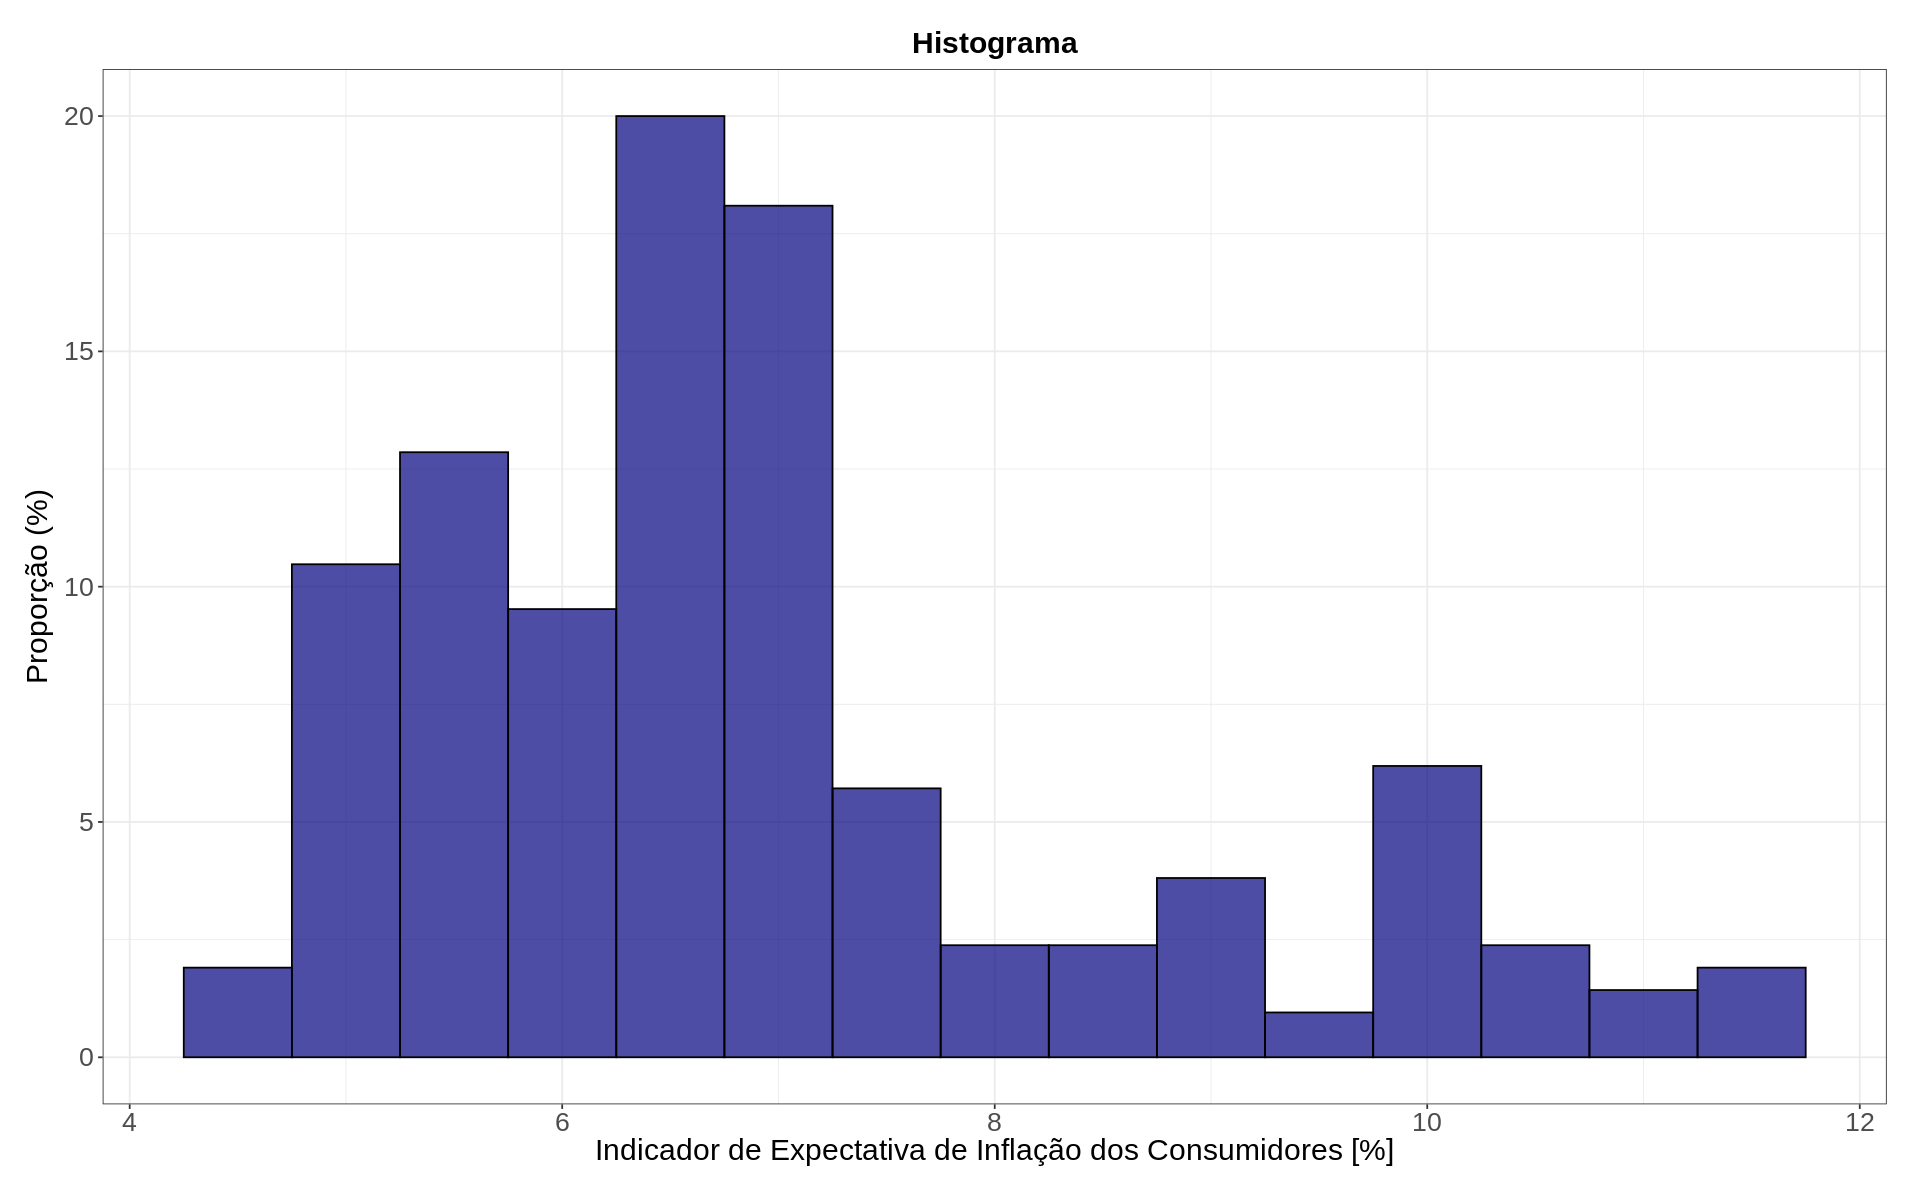

In [9]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 16, repr.plot.height = 10)

# Plotar o histograma dos valores da coluna "consumer_inflation_expectation"
ggplot(df_public_data, aes(x = consumer_inflation_expectation, y = 100 * after_stat(count) / sum(after_stat(count)))) +
  geom_histogram(binwidth = 0.5, color = "black", fill = "navy", alpha = 0.7) +
  labs(x = "Indicador de Expectativa de Inflação dos Consumidores [%]", y = "Proporção (%)", title = "Histograma") +
  theme_bw() +
  theme(
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
    axis.text = element_text(size = 16),
    axis.title.y = element_text(size = 18, vjust = 2),  # Ajuste o vjust para controlar o espaço entre o nome do eixo e os números
    axis.title.x = element_text(size = 18),  # Ajuste o tamanho do nome do eixo x
    plot.caption = element_text(size = 14),
    plot.margin = margin(20, 20, 20, 20)
  )

### **Visualização de Dados**

Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.


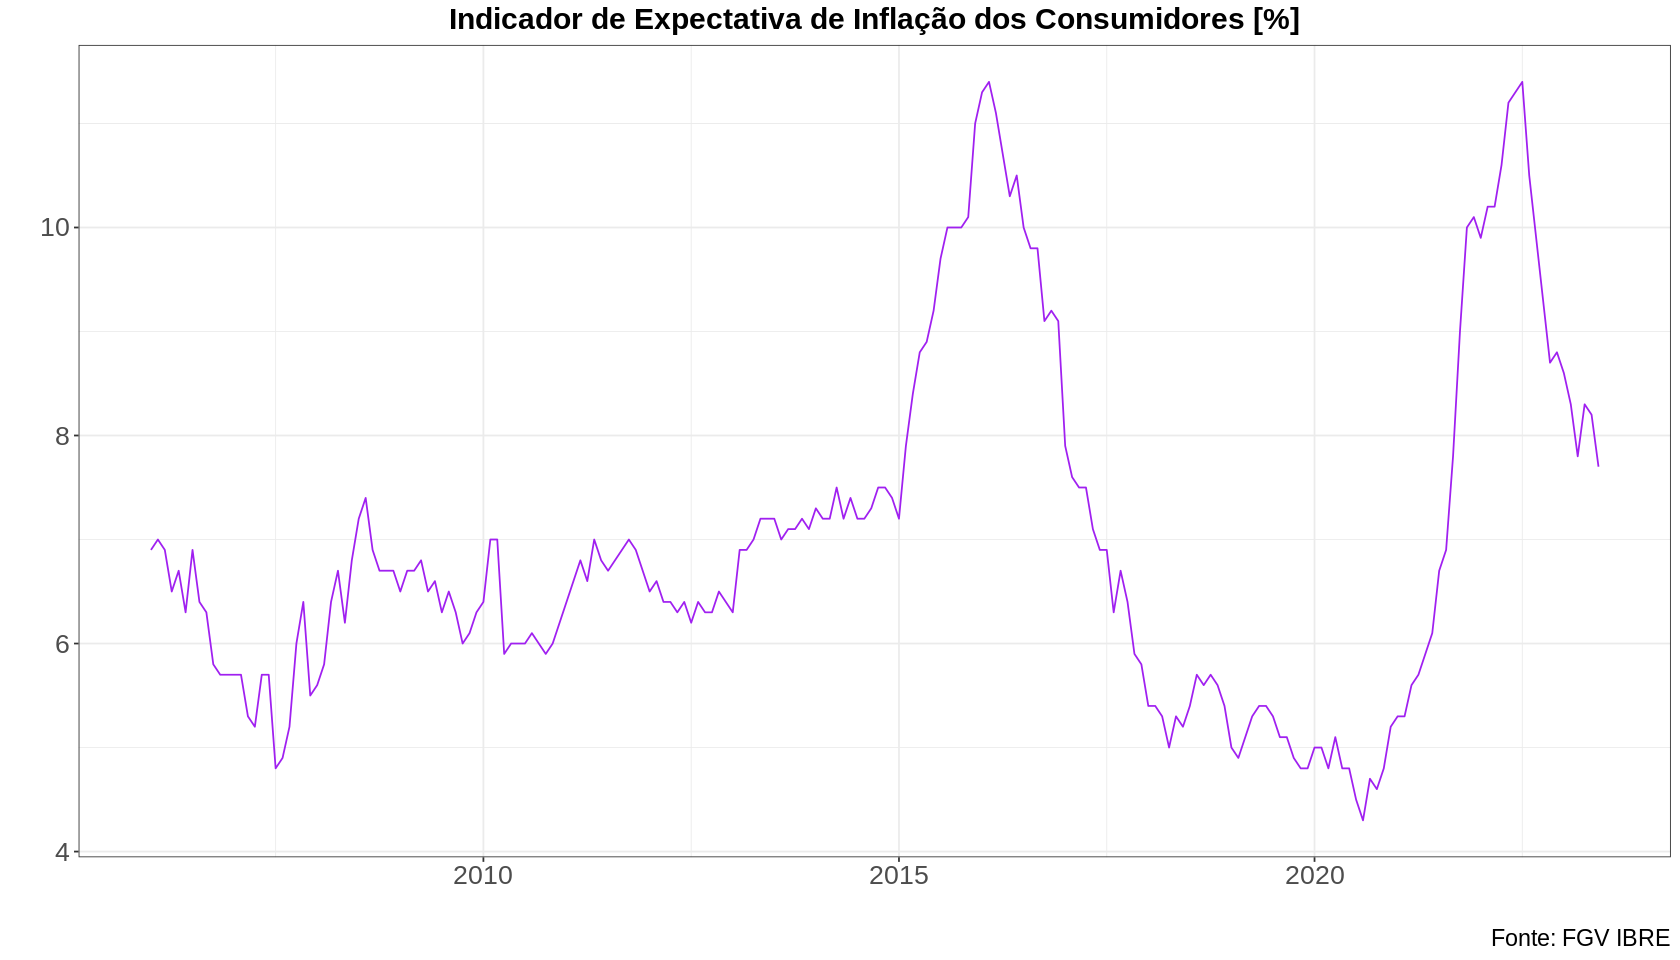

In [10]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 14, repr.plot.height = 8)

# Criar o objeto de plotagem usando ggplot
ggplot(df_public_data, aes(x = month, y = consumer_inflation_expectation)) +
  geom_line(color = "purple") +
  labs(x = "", y = "") +
  ggtitle("Indicador de Expectativa de Inflação dos Consumidores [%]") +
  theme_bw() +
  theme(plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
        axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        plot.caption = element_text(size = 14)) +
  labs(caption = "Fonte: FGV IBRE")

Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of typ

TableGrob (4 x 2) "arrange": 8 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]
4 4 (2-2,2-2) arrange gtable[layout]
5 5 (3-3,1-1) arrange gtable[layout]
6 6 (3-3,2-2) arrange gtable[layout]
7 7 (4-4,1-1) arrange gtable[layout]
8 8 (4-4,2-2) arrange gtable[layout]


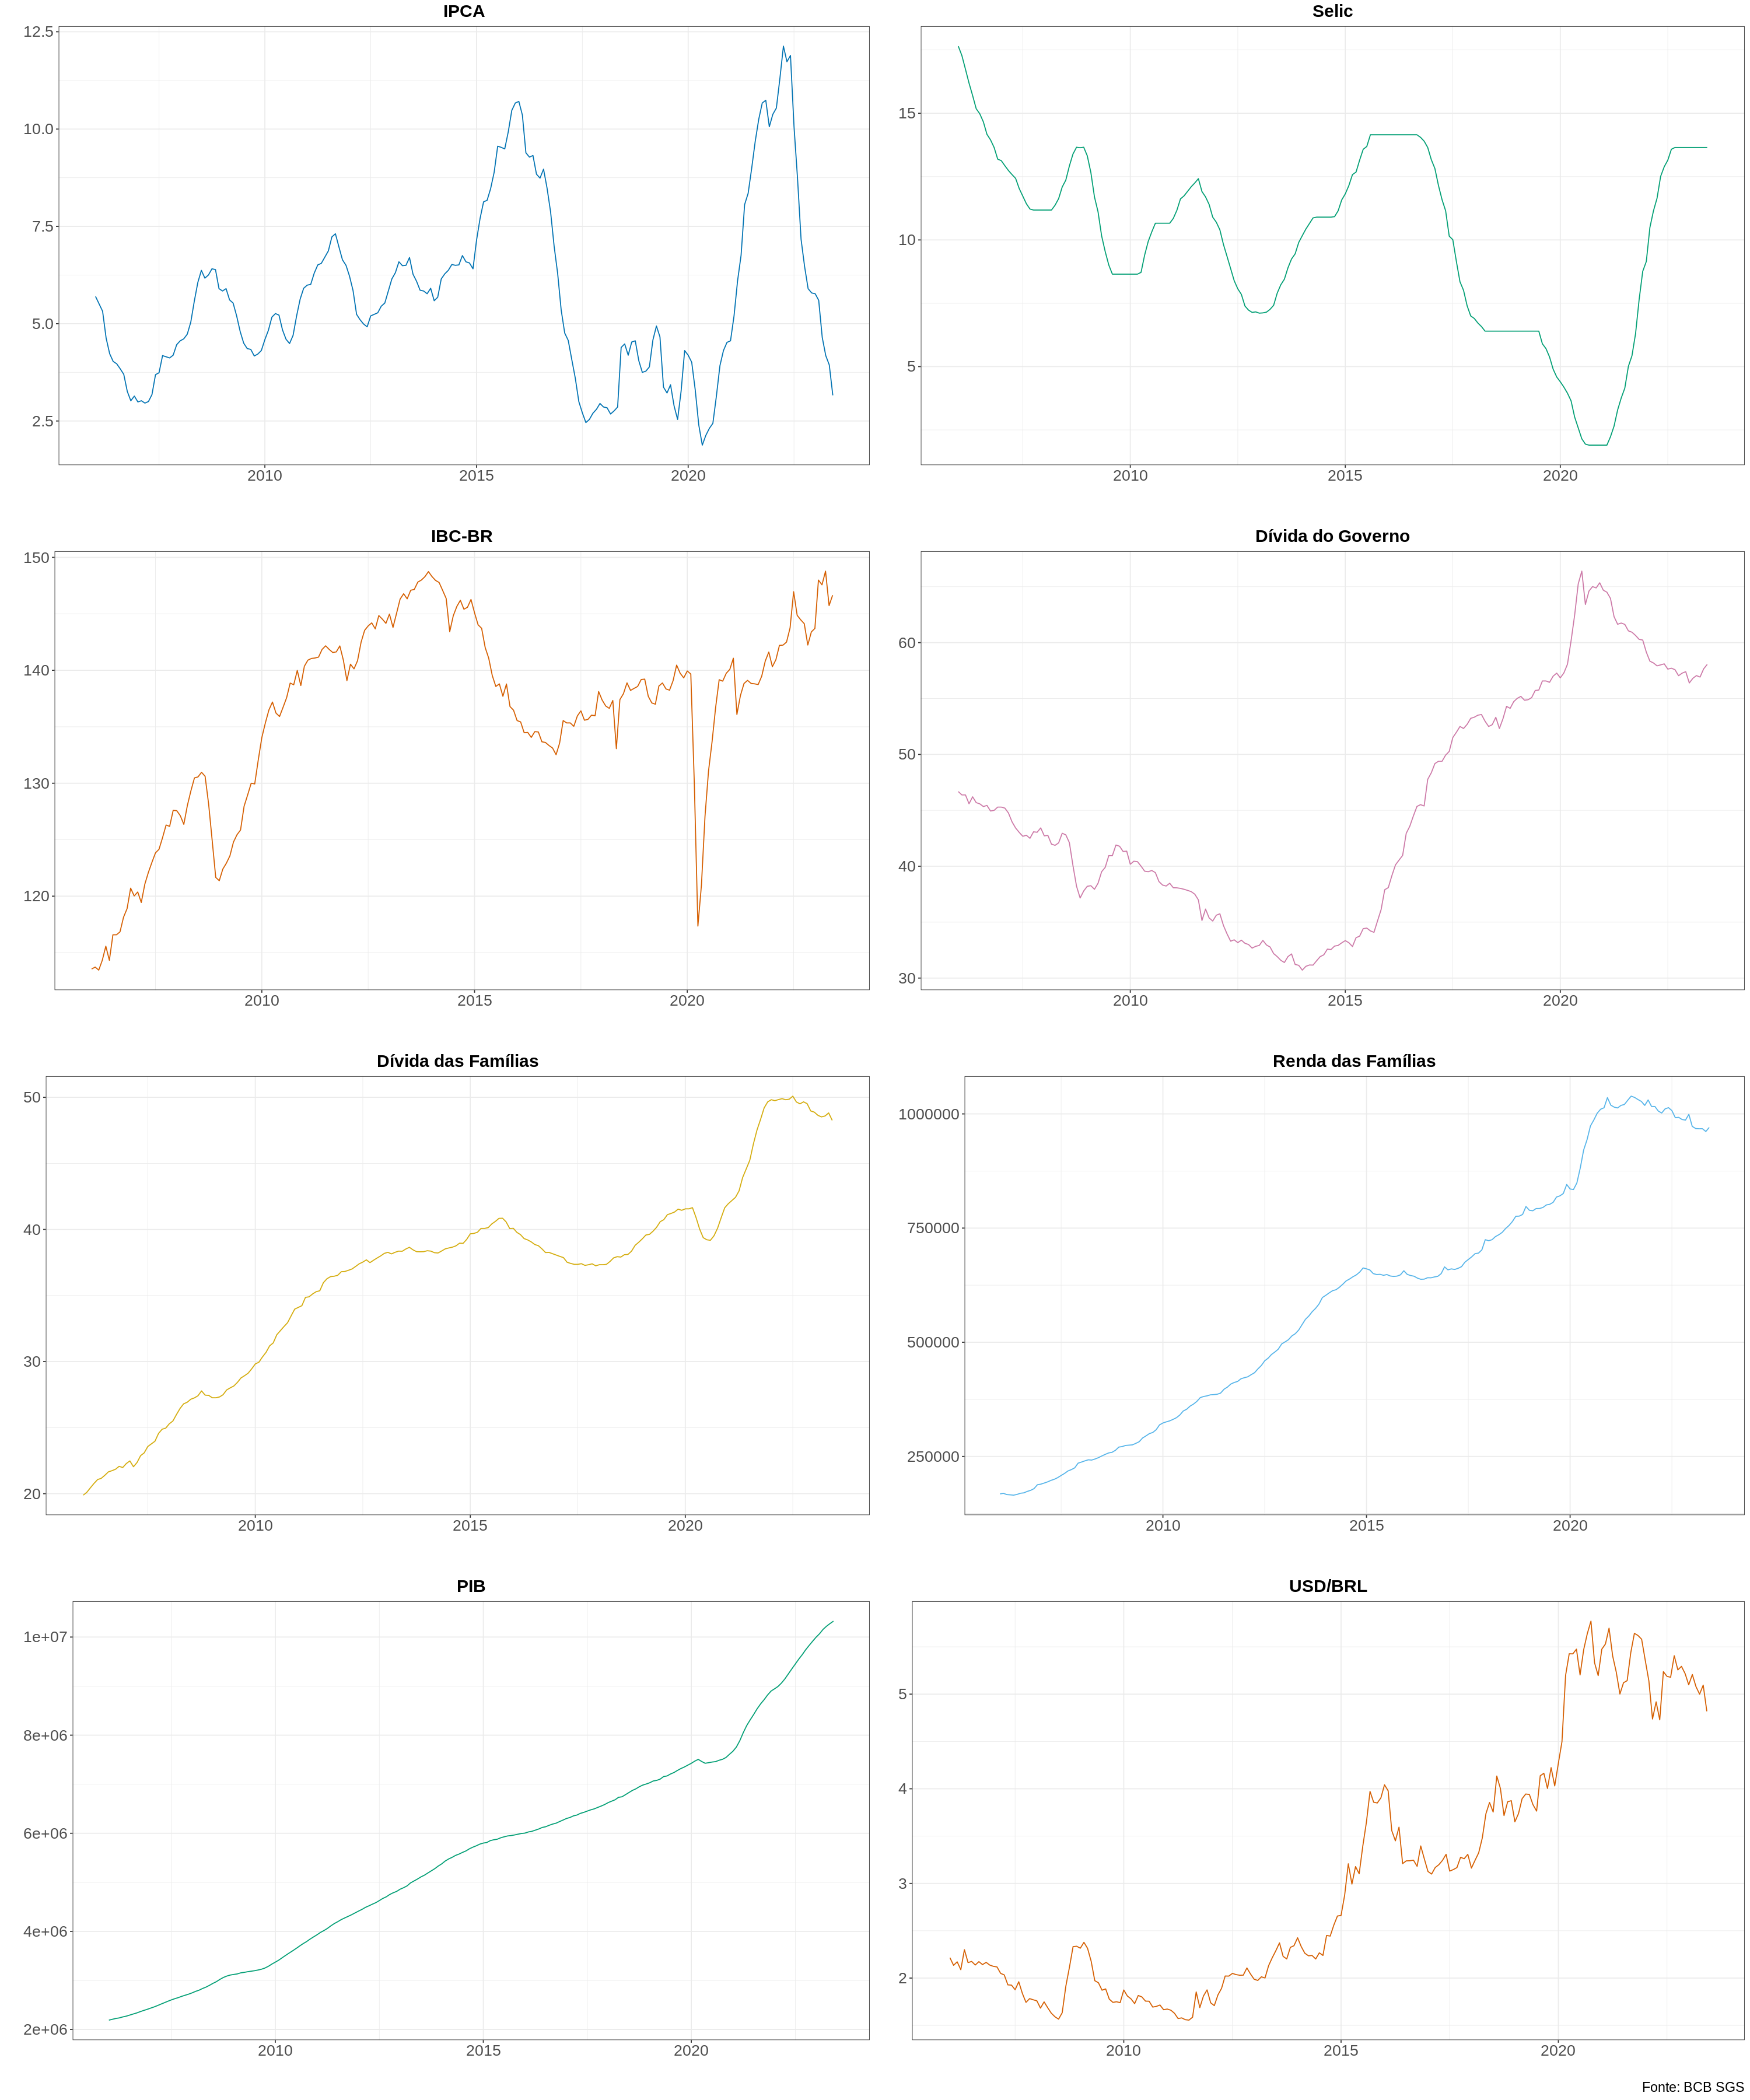

In [11]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 25, repr.plot.height = 30)  # Ajuste a altura para acomodar os 8 gráficos

# Lista de nomes das métricas
metricas <- c("ipca", "selic", "ibc_br", "gov_debt", "household_debt", "household_income", "pib", "usd_brl")

# Lista de títulos das métricas
titulos <- c("IPCA", "Selic", "IBC-BR", "Dívida do Governo", "Dívida das Famílias", "Renda das Famílias", "PIB", "USD/BRL")

# Lista de cores personalizadas
cores <- c("#0072B2", "#009E73", "#D55E00", "#CC79A7", "#D4AC0D", "#56B4E9", "#009E73", "#D55E00")

# Criar uma lista para armazenar os gráficos
graficos <- list()

# Criar os gráficos para cada métrica
for (i in 1:length(metricas)) {
  nome_metrica <- tolower(metricas[i])
  caption <- if (i == length(metricas)) "Fonte: BCB SGS" else ""  # Adicione a fonte apenas para o último gráfico
  grafico <- ggplot(df_public_data) +
    geom_line(aes(x = month, y = .data[[metricas[i]]]), color = cores[i]) +
    labs(x = "", y = "", title = titulos[i], caption = caption) +
    theme_bw() +
    theme(legend.position = "none",
          plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
          axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          plot.caption = element_text(size = 14))
  graficos[[i]] <- grafico
}

# Combinar os gráficos em um único painel
painel <- do.call(grid.arrange, c(graficos, ncol = 2))

# Apresentar o painel
print(painel)

### **Análise de Estacionariedade**

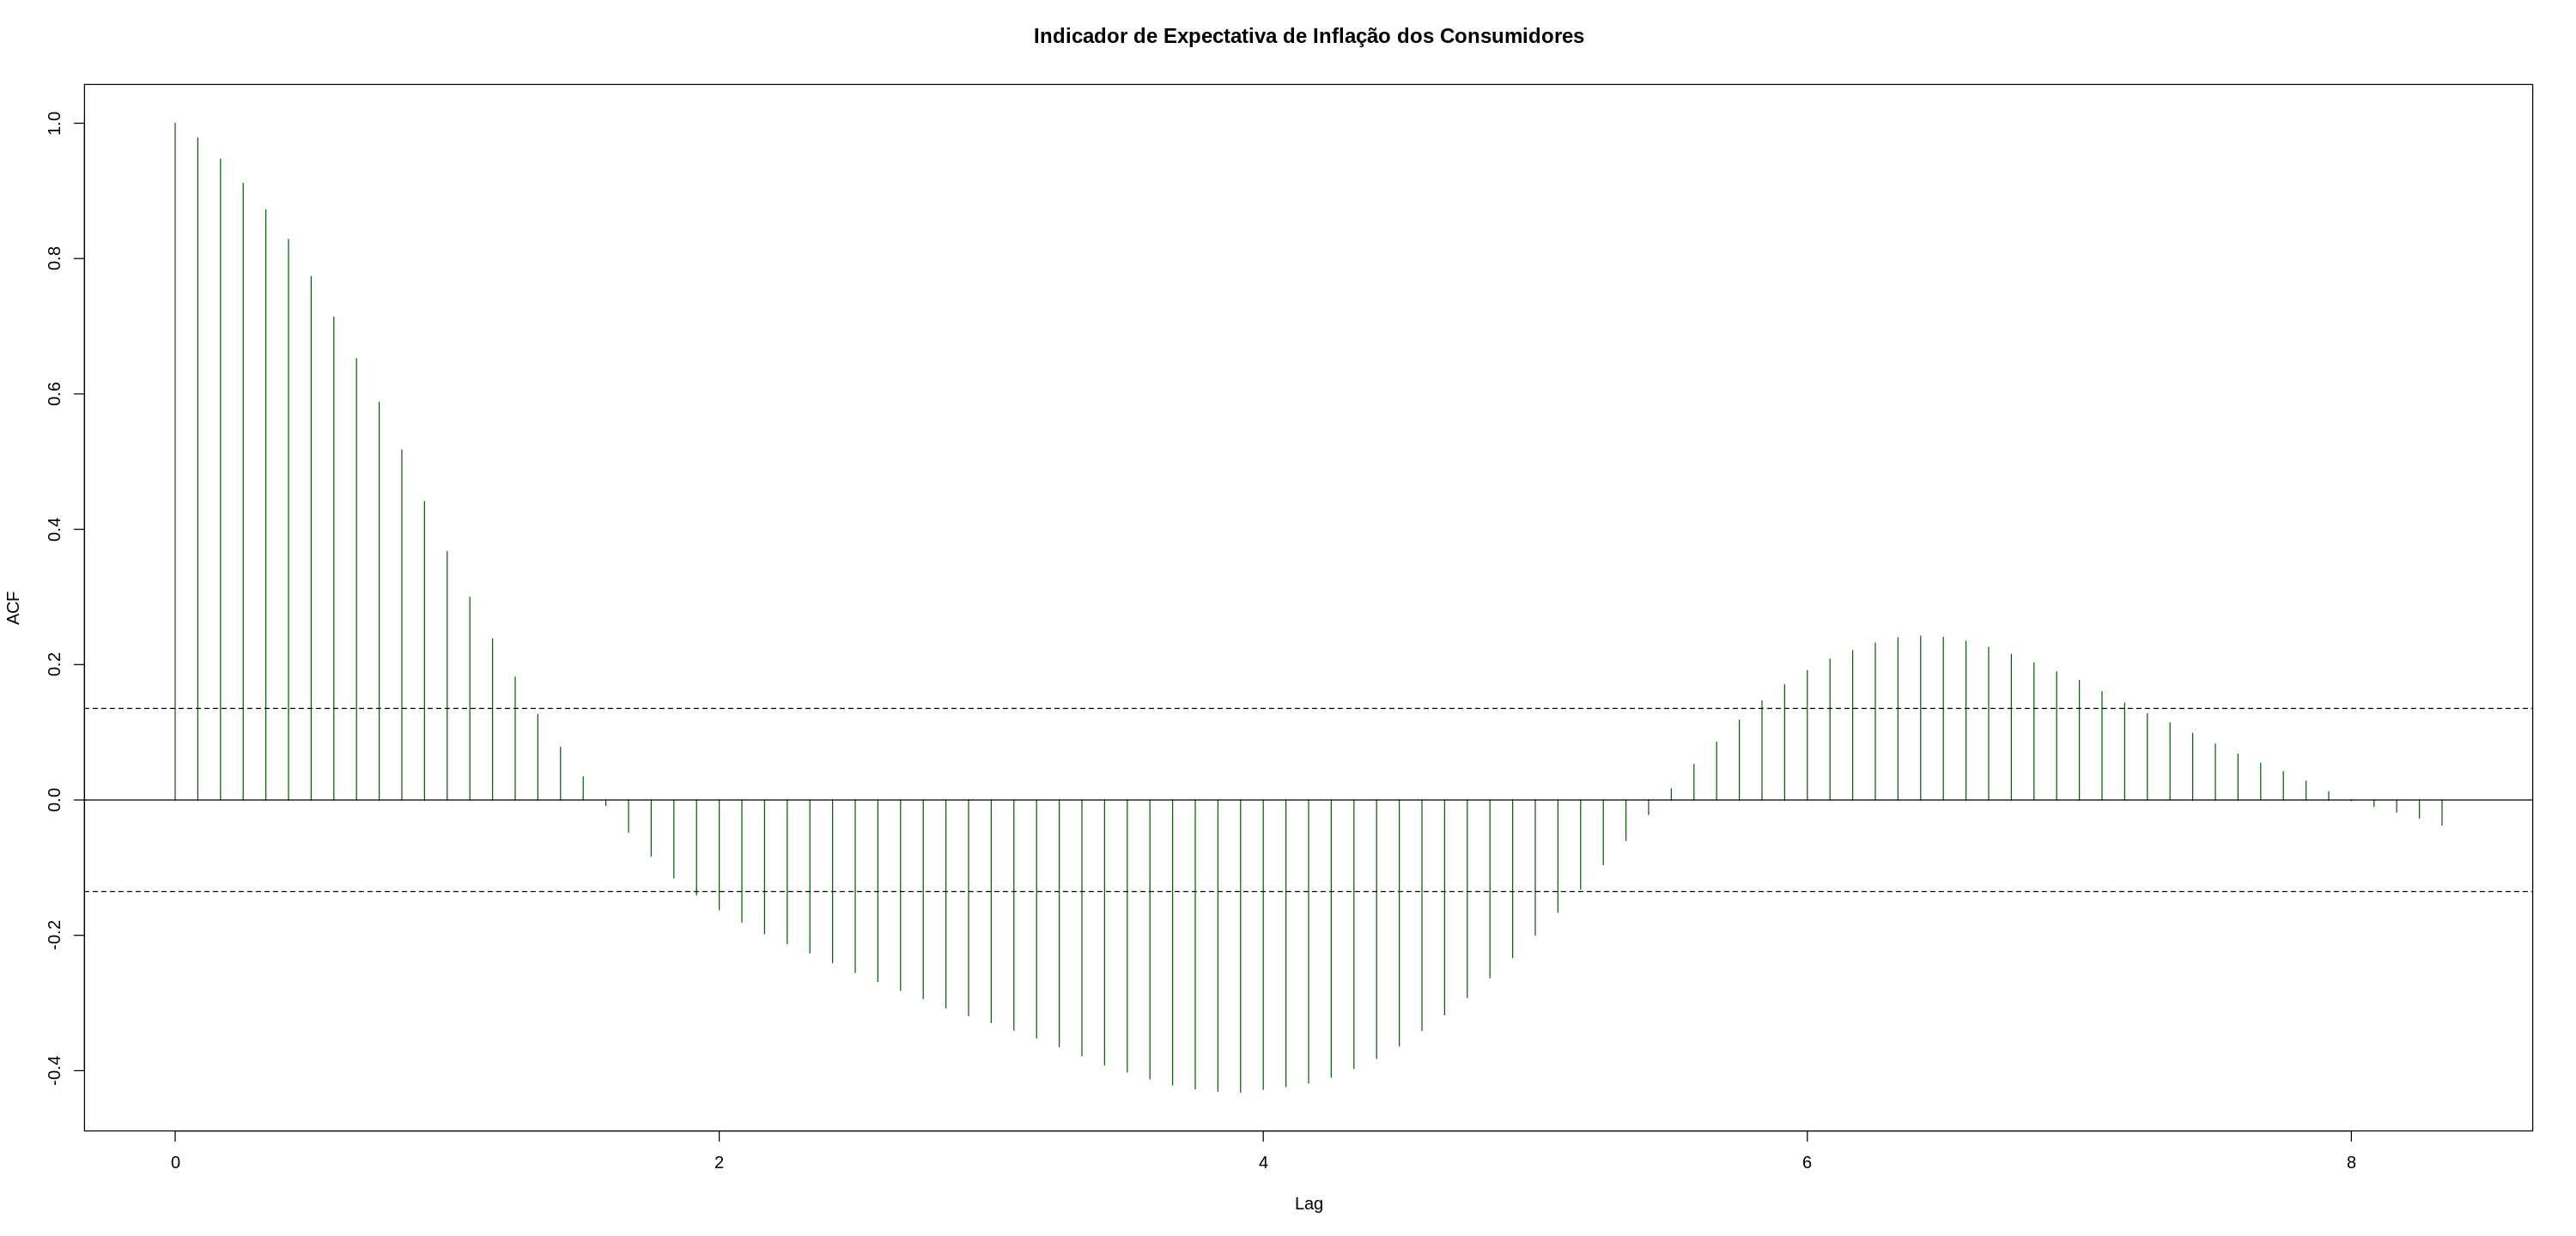

In [12]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 25, repr.plot.height = 12)  # Ajuste a altura para acomodar os 8 gráficos

# Função de Autocorrelação
acf(df_public_data$consumer_inflation_expectation,
    main = "Indicador de Expectativa de Inflação dos Consumidores",
    col = "darkgreen",
    ci.col = "black",
    lag.max = 100)

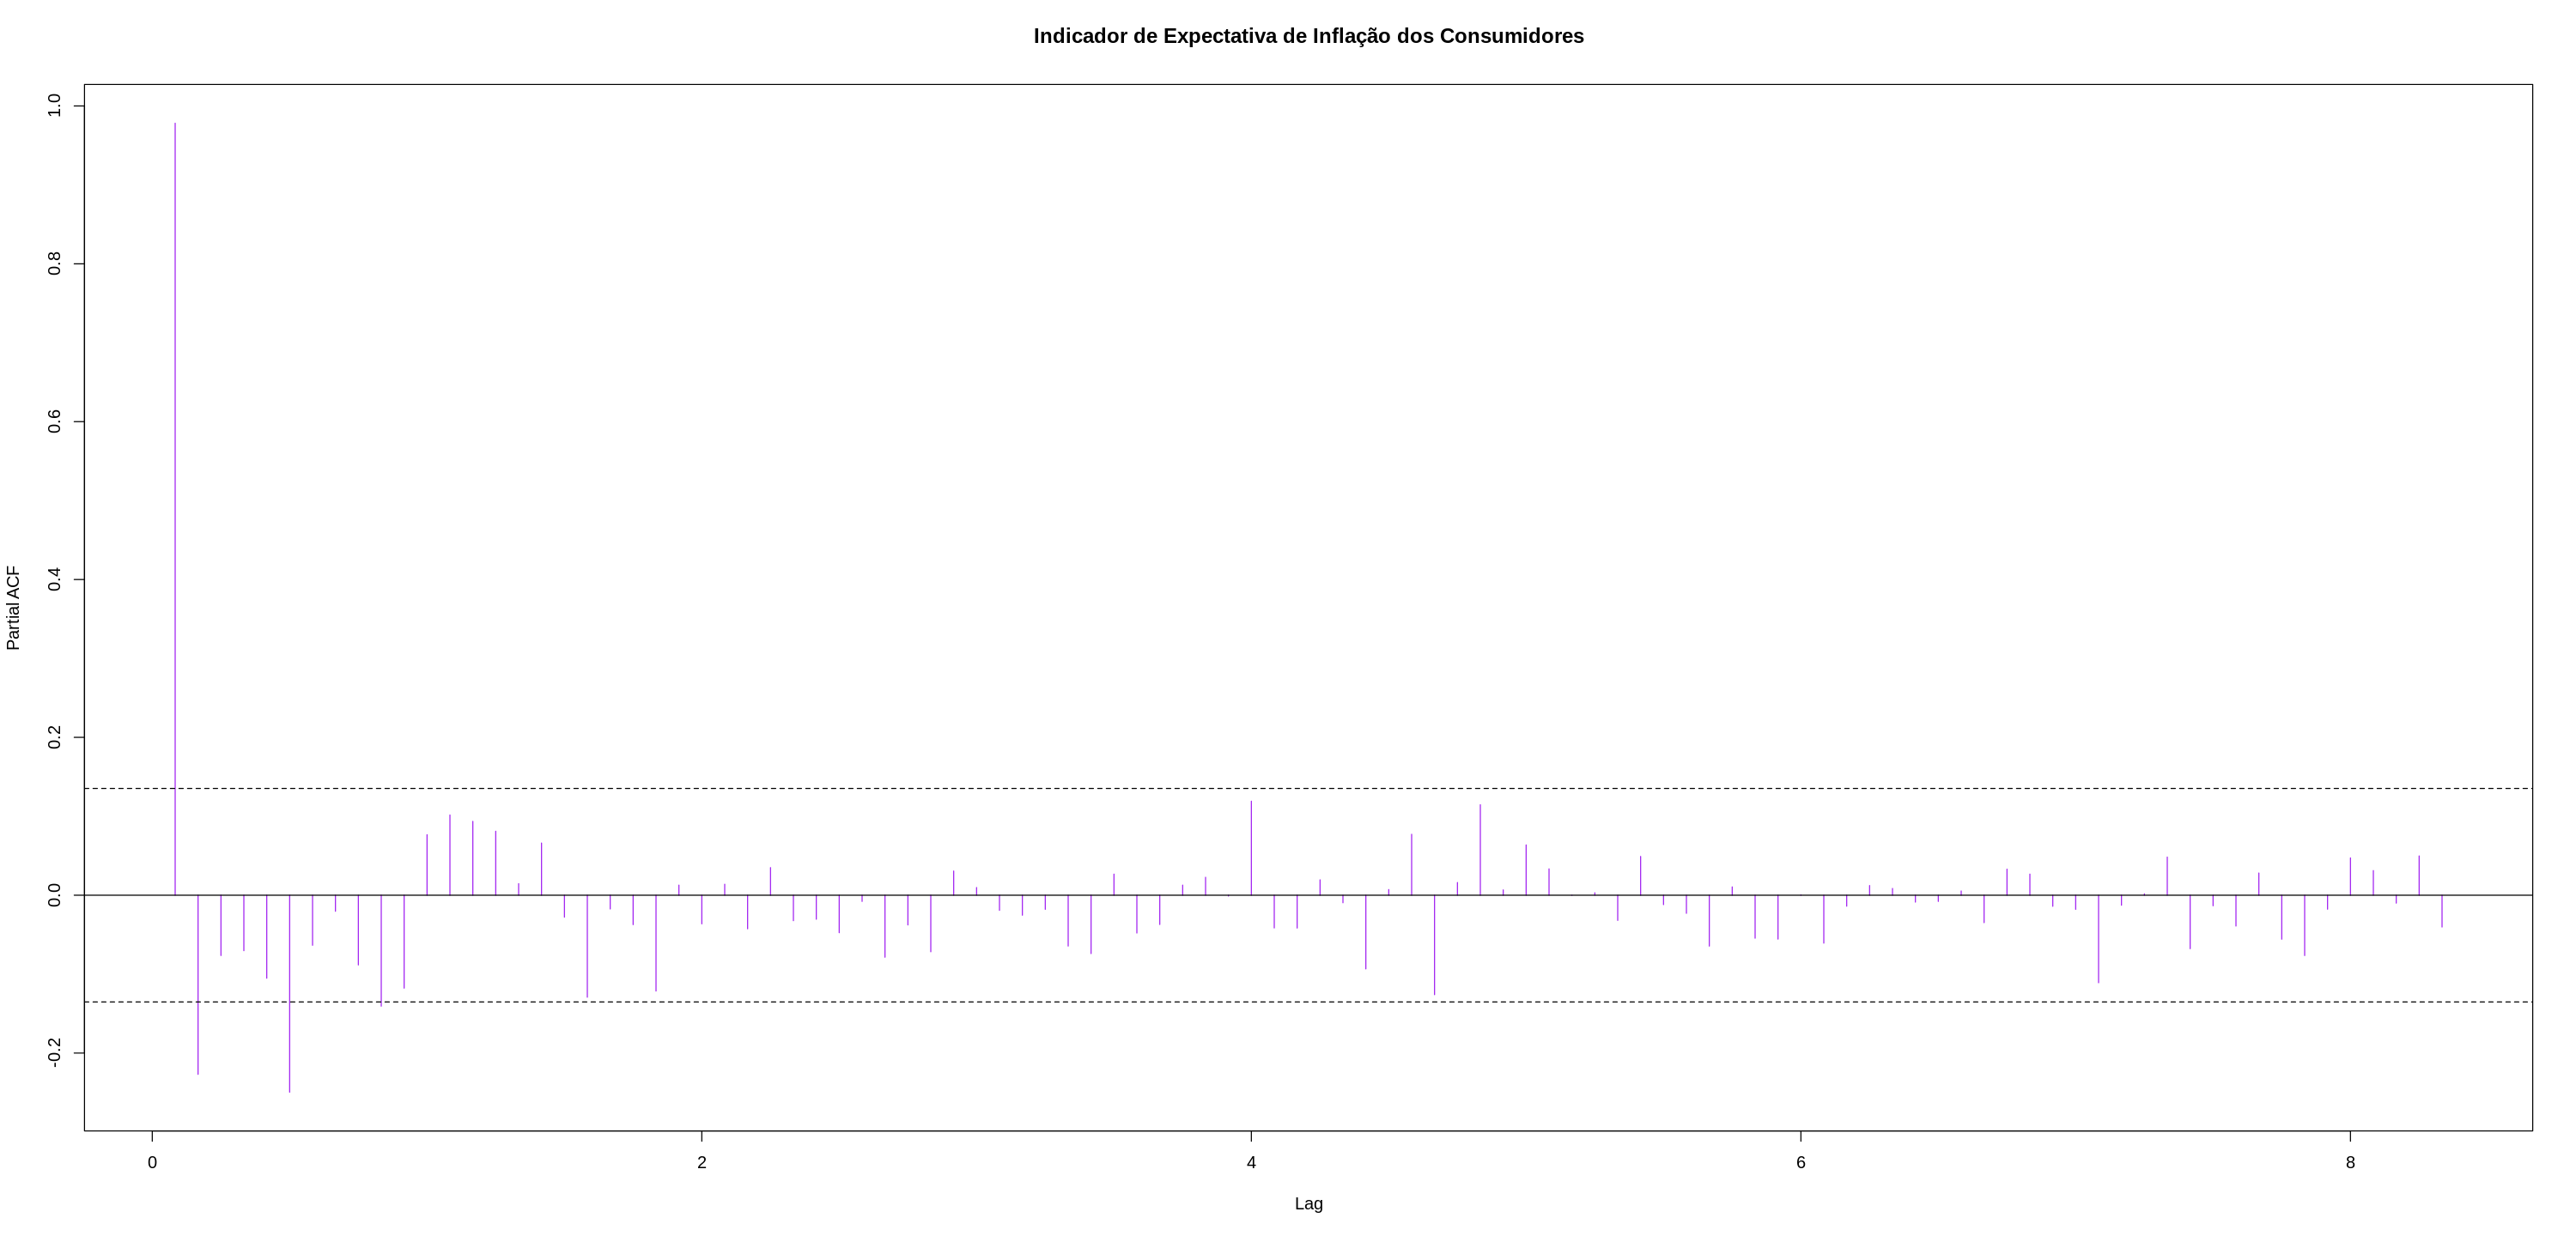

In [13]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 25, repr.plot.height = 12)  # Ajuste a altura para acomodar os 8 gráficos

# Função de Autocorrelação Parcial
pacf(df_public_data$consumer_inflation_expectation,
    main = "Indicador de Expectativa de Inflação dos Consumidores",
    col = "purple",
    ci.col = "black",
    lag.max = 100)

In [14]:
### Teste de Raiz Unitária (ADF)
summary( ur.df( df_public_data$consumer_inflation_expectation, lags=12, type='trend') )


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.09677 -0.18560 -0.00357  0.16660  0.94785 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)   
(Intercept)   0.3515298  0.1292630   2.719  0.00717 **
z.lag.1      -0.0534263  0.0184523  -2.895  0.00425 **
tt            0.0002051  0.0004114   0.499  0.61869   
z.diff.lag1   0.1955855  0.0717856   2.725  0.00707 **
z.diff.lag2   0.0156361  0.0723755   0.216  0.82920   
z.diff.lag3   0.1000963  0.0732853   1.366  0.17367   
z.diff.lag4  -0.0227473  0.0732961  -0.310  0.75665   
z.diff.lag5   0.2425796  0.0732023   3.314  0.00111 **
z.diff.lag6   0.0650533  0.0745469   0.873  0.38400   
z.diff.lag7   0.0350018  0.0735912   0.476  0.63491   
z.diff.lag8   0.0362034  0.0732818   0.494 

**Resultado**

- Como, em módulo, os valores de test-statistic são menores que tau3, phi2 e phi3, não se rejeita nenhuma das hipóteses nulas para um nível de significância de 5%, ou seja, a série temporal possui raiz unitária, o que significa que é não-estacionária.

In [15]:
### Teste de Raiz Unitária (KPSS)
summary( ur.kpss( df_public_data$consumer_inflation_expectation, type = "tau",     # média diferente de zero
                              lags = "short"    # poucos lags
                              ) )


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: tau with 4 lags. 

Value of test-statistic is: 0.2148 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.119 0.146  0.176 0.216


**Resultado**

- Como, em módulo, o valor de test-statistic é maior que o valor crítico, rejeita-se a hipótese nula para um nível de significância de 5%, ou seja, a série possui raiz unitária, o que significa que é não-estacionária.

### **Modelo Linear**

In [16]:
# Criar modelo de regressão linear
ols_model <- lm(df_public_data$consumer_inflation_expectation ~ df_public_data$ipca)

summary(ols_model)


Call:
lm(formula = df_public_data$consumer_inflation_expectation ~ 
    df_public_data$ipca)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.51555 -0.62455 -0.07287  0.38900  2.34423 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)          3.41230    0.17214   19.82   <2e-16 ***
df_public_data$ipca  0.62017    0.02811   22.07   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9114 on 208 degrees of freedom
Multiple R-squared:  0.7007,	Adjusted R-squared:  0.6992 
F-statistic: 486.9 on 1 and 208 DF,  p-value: < 2.2e-16


Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
`geom_smooth()` using formula = 'y ~ x'


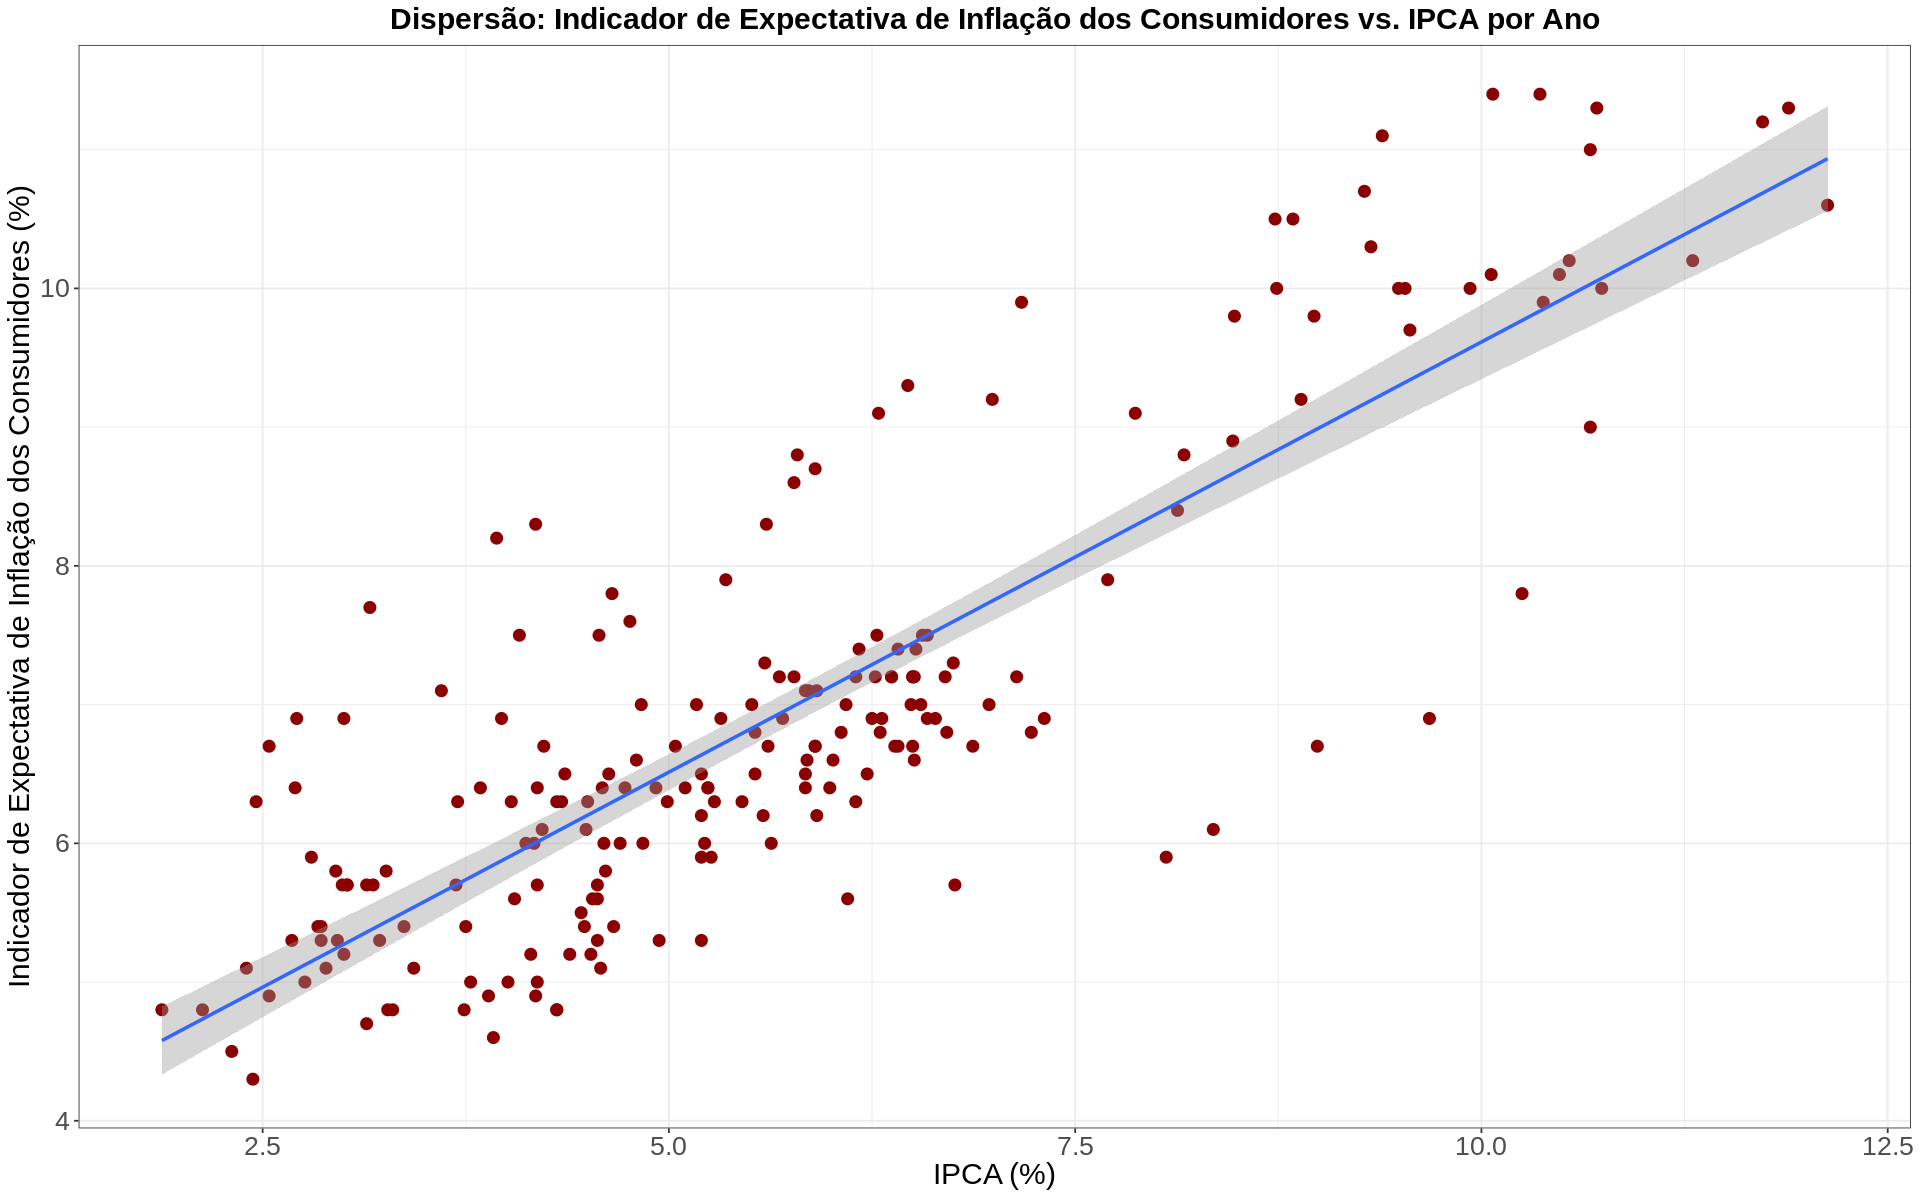

In [17]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 16, repr.plot.height = 10)

# Plotar o gráfico de dispersão de "consumer_inflation_expectation" e "ipca" com regressão linear
ggplot(df_public_data, aes(x = ipca, y = consumer_inflation_expectation)) +
  geom_point(color = "darkred", size = 3) +
  geom_smooth(method = "lm") +
  labs(x = "IPCA (%)", y = "Indicador de Expectativa de Inflação dos Consumidores (%)", title = "Dispersão: Indicador de Expectativa de Inflação dos Consumidores vs. IPCA por Ano") +
  theme_bw() +
  theme(legend.text = element_text(size = 12),
        legend.title = element_text("Ano"),
        plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
        axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        plot.caption = element_text(size = 14))

### **Modelo VAR**

In [18]:
# Criar variáveis de inflação
inflation_variables <- cbind(consumer_inflation_expectation, ipca)

In [100]:
# Selecionar a ordem adequada do modelo VAR
lag_select <- VARselect(inflation_variables, lag.max = 12, type = "const")

print(lag_select$selection)

AIC(n)  HQ(n)  SC(n) FPE(n) 
     2      2      2      2 


In [20]:
# Ajustar o modelo VAR com uma ordem escolhida
var_model = VAR(inflation_variables, p = 2, type = "const", season = NULL, exog = NULL)

summary(var_model)


VAR Estimation Results:
Endogenous variables: consumer_inflation_expectation, ipca 
Deterministic variables: const 
Sample size: 208 
Log Likelihood: -113.607 
Roots of the characteristic polynomial:
0.9456 0.9456 0.4911 0.04001
Call:
VAR(y = inflation_variables, p = 2, type = "const", exogen = NULL)


Estimation results for equation consumer_inflation_expectation: 
consumer_inflation_expectation = consumer_inflation_expectation.l1 + ipca.l1 + consumer_inflation_expectation.l2 + ipca.l2 + const 

                                   Estimate Std. Error t value Pr(>|t|)    
consumer_inflation_expectation.l1  0.848359   0.069748  12.163  < 2e-16 ***
ipca.l1                            0.288681   0.049192   5.868 1.77e-08 ***
consumer_inflation_expectation.l2  0.001713   0.062624   0.027 0.978202    
ipca.l2                           -0.165977   0.056325  -2.947 0.003586 ** 
const                              0.344909   0.102941   3.351 0.000962 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.

In [23]:
# Serial Correlation
serial_test <- serial.test(var_model, lags.pt = 12, type = "PT.asymptotic")

print(serial_test)


	Portmanteau Test (asymptotic)

data:  Residuals of VAR object var_model
Chi-squared = 82.39, df = 40, p-value = 9.13e-05



$serial

	Portmanteau Test (asymptotic)

data:  Residuals of VAR object var_model
Chi-squared = 82.39, df = 40, p-value = 9.13e-05



**Resultado**

- Como o p-value é menor que um nível de significância de 5%, não se pode afirmar que as variáveis não possuem correlação serial

In [24]:
# Heteroscedasticity
arch_test <- arch.test(var_model, lags.multi = 12, multivariate.only = TRUE)

print(arch_test)


	ARCH (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 112.77, df = 108, p-value = 0.3575



$arch.mul

	ARCH (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 112.77, df = 108, p-value = 0.3575



**Resultado**

- Como o p-value é maior que um nível de significância de 5%, pode-se afirmar que o modelo não possui heteroscedasticidade

In [27]:
# Normal Distribution of Residuals
normal_test <- normality.test(var_model, multivariate.only = TRUE)

print(normal_test)

$JB

	JB-Test (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 113.07, df = 4, p-value < 2.2e-16


$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 2.4751, df = 2, p-value = 0.2901


$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 110.59, df = 2, p-value < 2.2e-16




$jb.mul
$jb.mul$JB

	JB-Test (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 113.07, df = 4, p-value < 2.2e-16


$jb.mul$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 2.4751, df = 2, p-value = 0.2901


$jb.mul$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 110.59, df = 2, p-value < 2.2e-16




**Resultado**

- Como o p-value é menor que um nível de significância de 5% no JB-test, não se pode afirmar que os resíduos são distribuídos de forma gaussiana

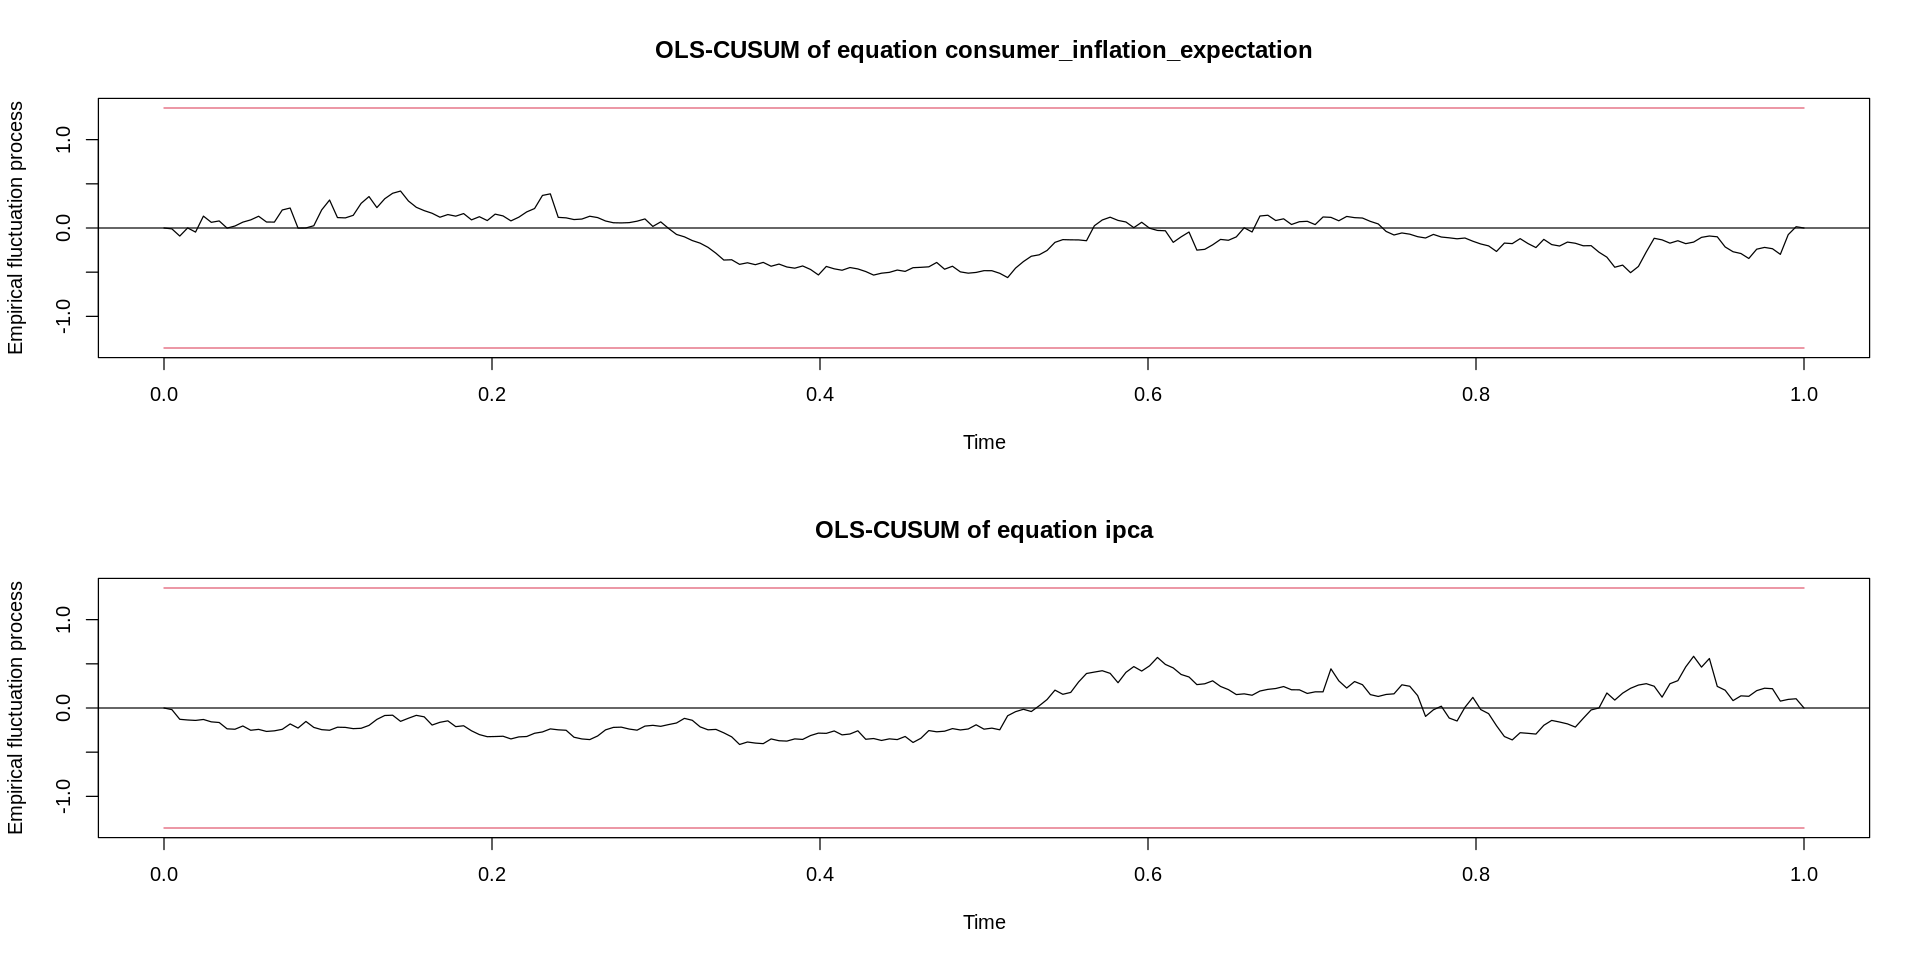

In [34]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 16, repr.plot.height = 8)

# Structural Breaks in Residuals
stability_test <- stability(var_model, type = "OLS-CUSUM")

plot(stability_test)

**Resultado**

- Como os valores estão entre as barras vermelhas, pode-se afirmar que não há quebra estrutural nos resíduos

In [35]:
# Granger Causality
granger_consumer_expectation <- causality(var_model, cause = "ipca")

print(granger_consumer_expectation)

$Granger

	Granger causality H0: ipca do not Granger-cause
	consumer_inflation_expectation

data:  VAR object var_model
F-Test = 43.704, df1 = 2, df2 = 406, p-value < 2.2e-16


$Instant

	H0: No instantaneous causality between: ipca and
	consumer_inflation_expectation

data:  VAR object var_model
Chi-squared = 2.0101, df = 1, p-value = 0.1563




**Resultado**

- Como o p-valor é menor que um nível de significância de 5%, pode-se rejeitar a hipótese nula do teste de Granger e afirmar que IPCA causa, no sentido de Granger, variação na expectativa de inflação do consumidor

In [37]:
# Granger Causality
granger_ipca <- causality(var_model, cause = "consumer_inflation_expectation")

print(granger_ipca)

$Granger

	Granger causality H0: consumer_inflation_expectation do not
	Granger-cause ipca

data:  VAR object var_model
F-Test = 2.4731, df1 = 2, df2 = 406, p-value = 0.08559


$Instant

	H0: No instantaneous causality between: consumer_inflation_expectation
	and ipca

data:  VAR object var_model
Chi-squared = 2.0101, df = 1, p-value = 0.1563




**Resultado**

- Como o p-valor é maior que um nível de significância de 5%, não se pode rejeitar a hipótese nula do teste de Granger e afirmar que a expectativa de inflação do consumidor causa, no sentido de Granger, variação no IPCA

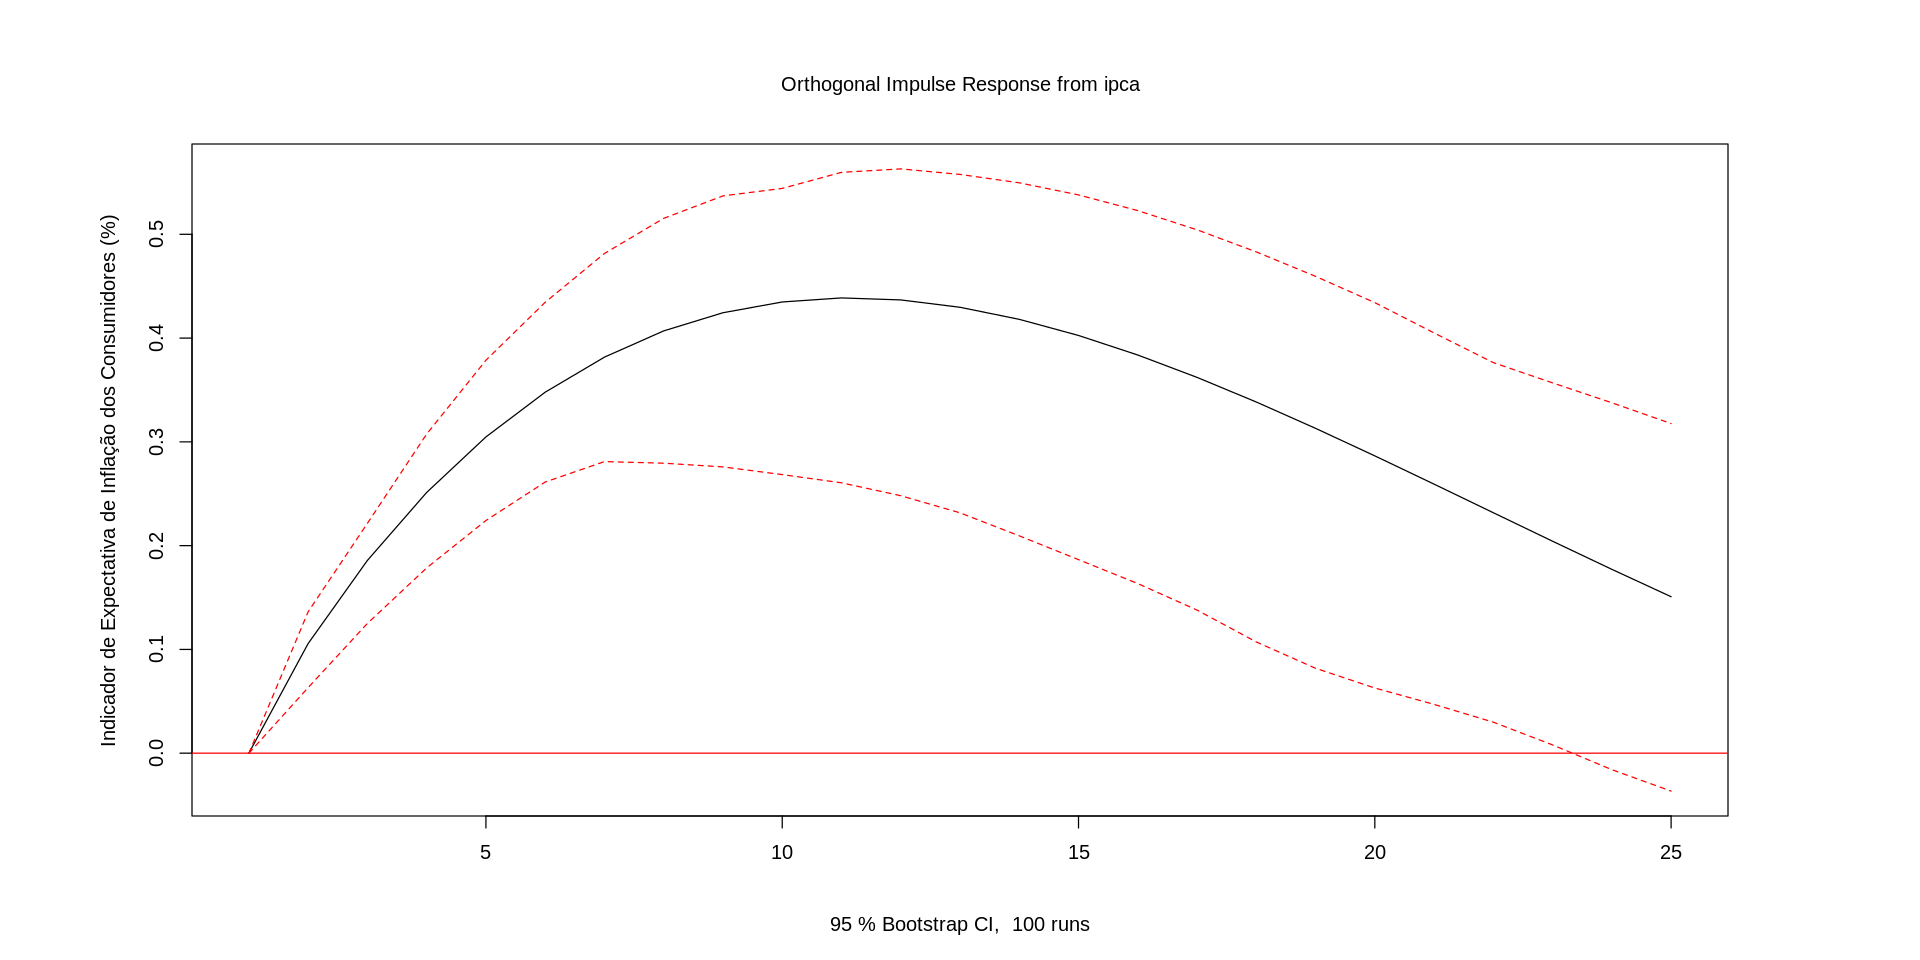

In [40]:
# Impulse Response Function
consumer_expectation_impulse = irf(var_model, impulse = "ipca", response = "consumer_inflation_expectation", n.ahead = 24, boot = TRUE)

plot(consumer_expectation_impulse, ylab = "Indicador de Expectativa de Inflação dos Consumidores (%)")

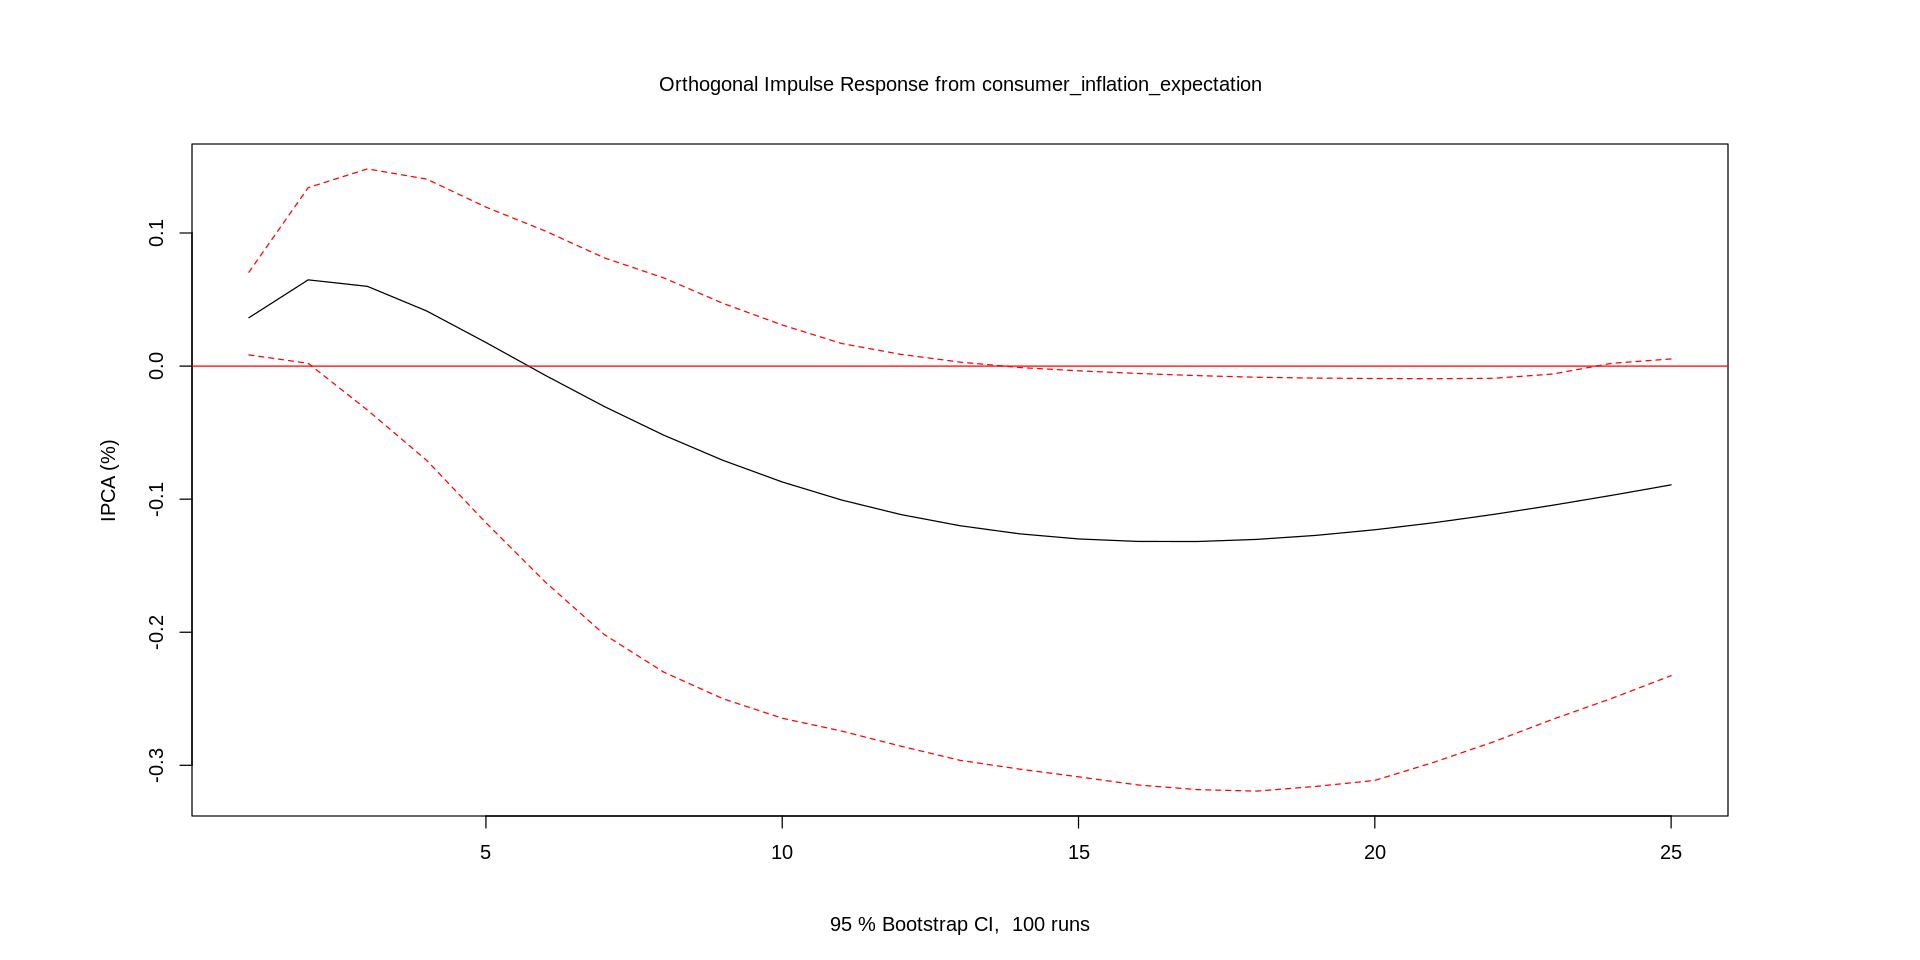

In [41]:
# Impulse Response Function
ipca_impulse = irf(var_model, impulse = "consumer_inflation_expectation", response = "ipca", n.ahead = 24, boot = TRUE)

plot(ipca_impulse, ylab = "IPCA (%)")

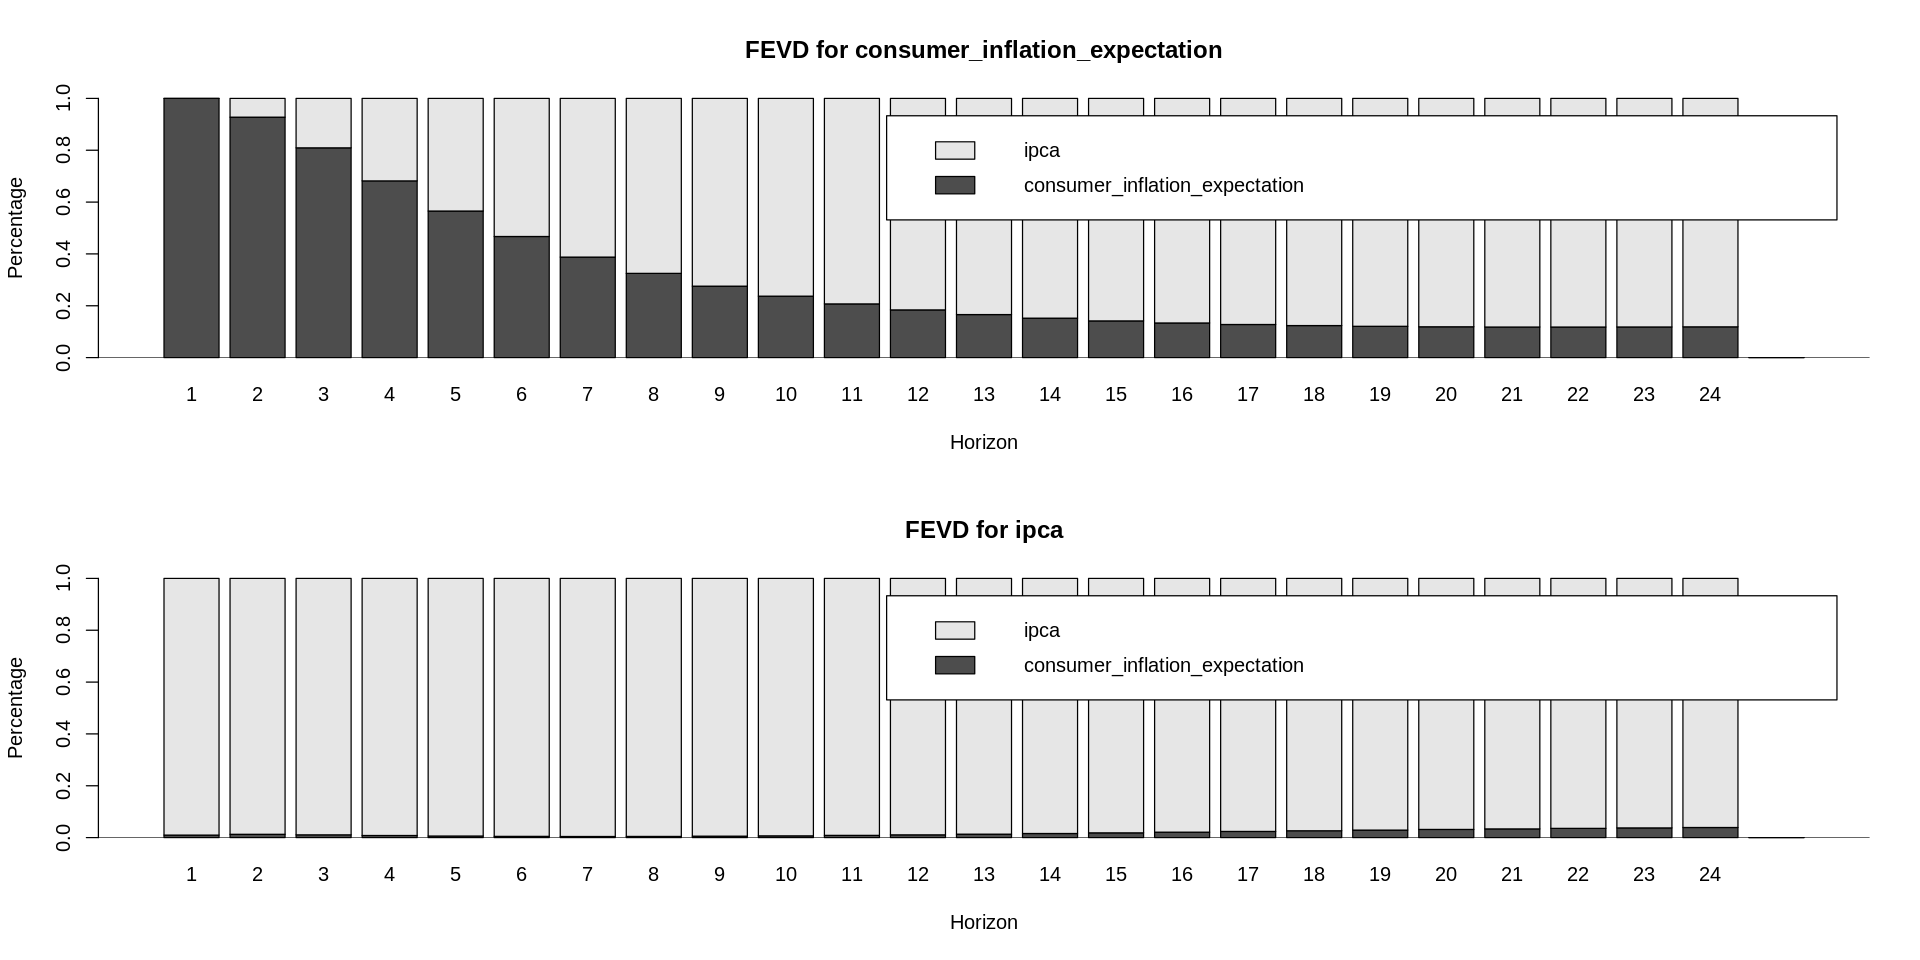

In [42]:
# Função de Variação de Valores Extremos
fevd_model <- fevd(var_model, n.ahead = 24)

plot(fevd_model)

**Resultado**

- Depois de ~6 meses, a expectativa de inflação é mais explicada pelo IPCA do que a própria variável expectativa de inflação

- A variável IPCA é, aproximadamente em sua totalidade, explicada pelo próprio IPCA

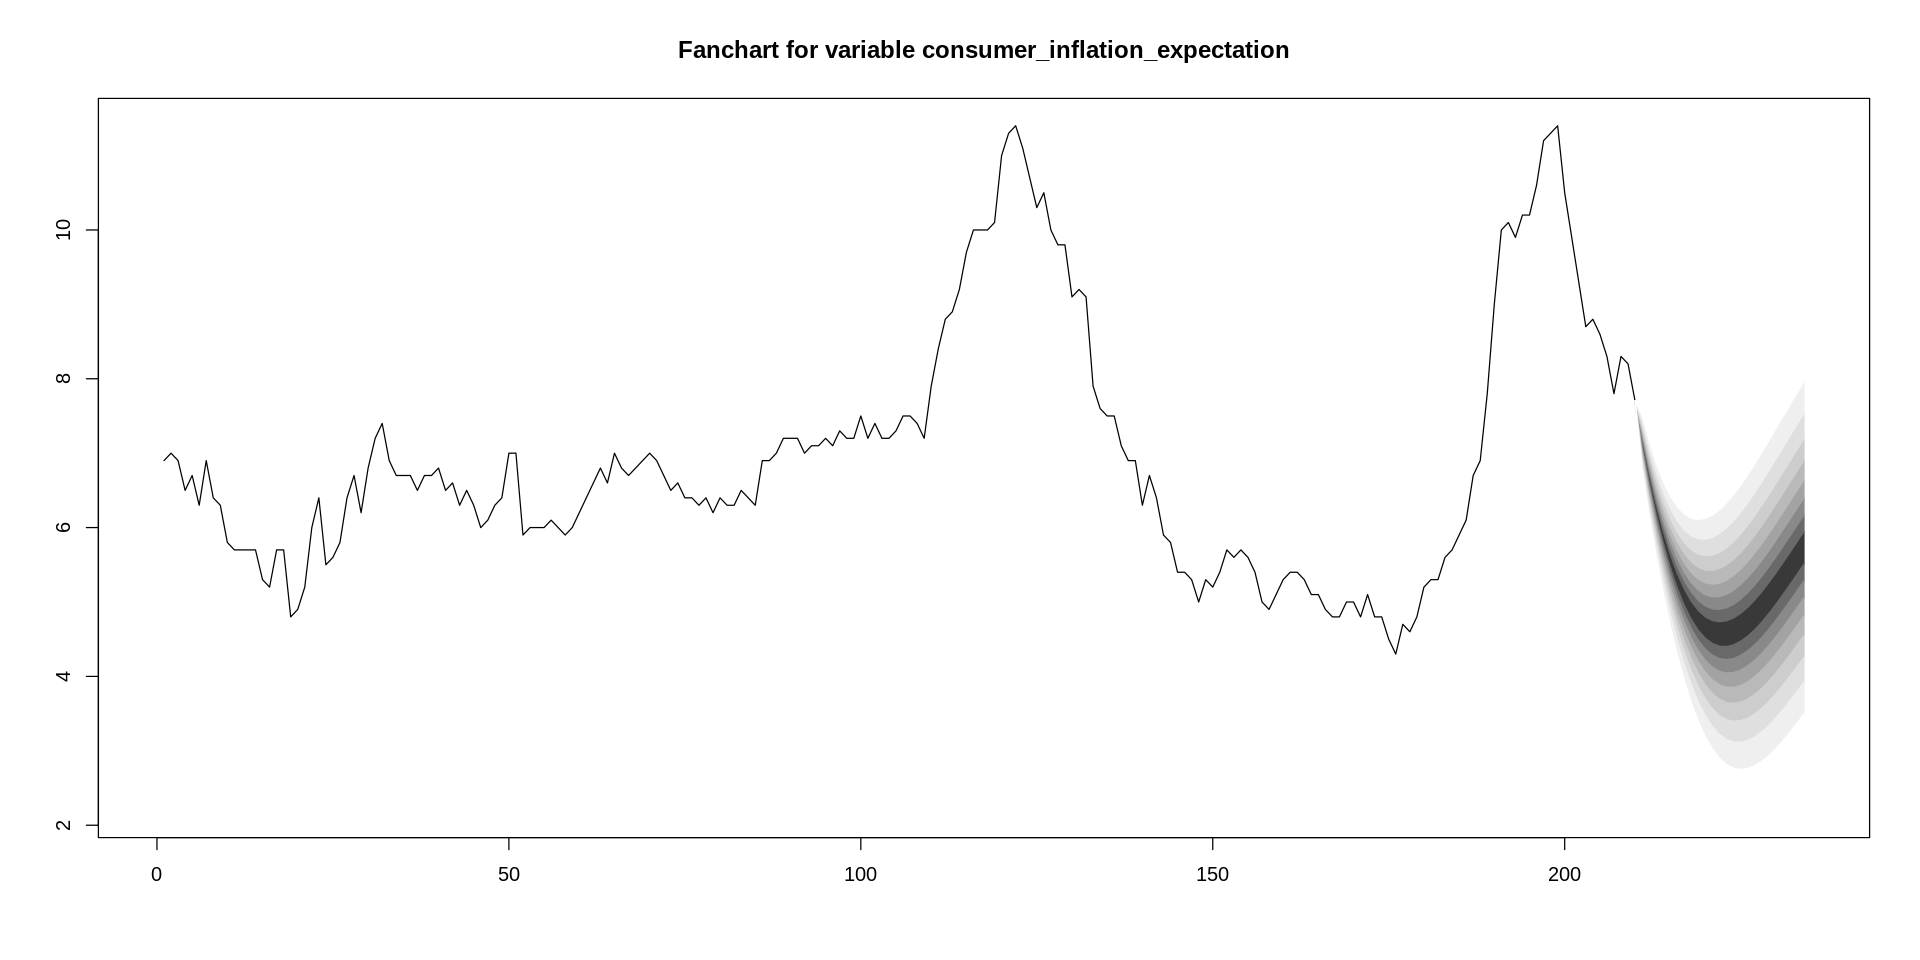

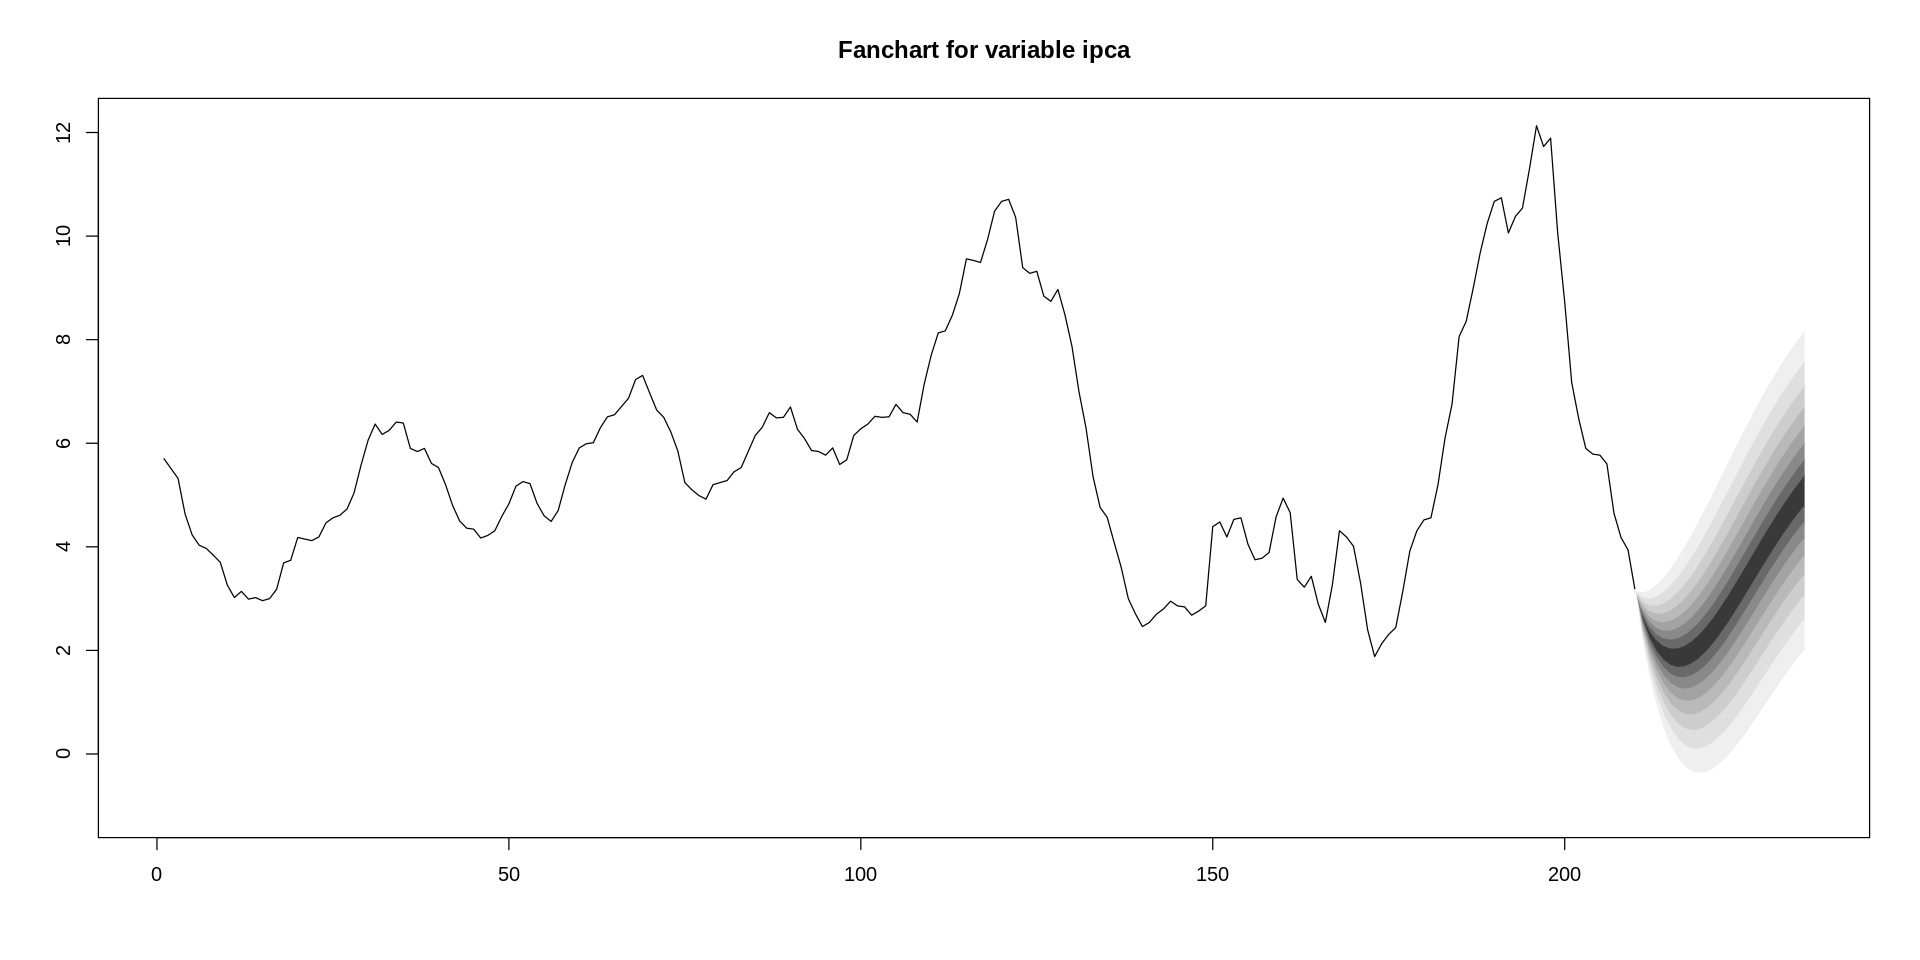

In [54]:
# Forecast using VAR
forecast_var <- predict(var_model, n.ahead = 24, ci = 0.95)

fanchart(forecast_var, names = "consumer_inflation_expectation")
fanchart(forecast_var, names = "ipca")

### **Modelo VECM**

In [79]:
# Lag Selection
vecm_lag <- VARselect(inflation_variables, lag.max = 12, type = "const")

print(vecm_lag$selection)

AIC(n)  HQ(n)  SC(n) FPE(n) 
     2      2      2      2 


In [116]:
# Johansen Test (Trace)
vecm_johansen_trace <- ca.jo(inflation_variables, type = "trace", ecdet = "const", K = 2)

summary(vecm_johansen_trace)


###################### 
# Johansen-Procedure # 
###################### 

Test type: trace statistic , without linear trend and constant in cointegration 

Eigenvalues (lambda):
[1] 1.564325e-01 5.171388e-02 2.775558e-17

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 1 | 11.04  7.52  9.24 12.97
r = 0  | 46.43 17.85 19.96 24.60

Eigenvectors, normalised to first column:
(These are the cointegration relations)

                                  consumer_inflation_expectation.l2     ipca.l2
consumer_inflation_expectation.l2                         1.0000000  1.00000000
ipca.l2                                                  -0.8318175 -0.02711544
constant                                                 -2.2270141 -6.64125434
                                    constant
consumer_inflation_expectation.l2   1.000000
ipca.l2                            -6.783783
constant                          162.624857

Weights W:
(This is the loading matrix)


**Resultado**

- r = 0: Como teststatistic é maior que critical value a um nível de significância de 1%, rejeita-se a hipótese nula, ou seja, existe ao menos 1 relação de cointegração no sistema

- r <= 1: Como teststatistic é menor que critical value a um nível de significância de 1%, não se rejeita a hipótese nula, ou seja, existe no máximo 1 relaçõe de cointegração no sistema

In [117]:
# Johansen Test (MaxEigen)
vecm_johansen_eigen <- ca.jo(inflation_variables, type = "eigen", ecdet = "const", K = 2)

summary(vecm_johansen_eigen)


###################### 
# Johansen-Procedure # 
###################### 

Test type: maximal eigenvalue statistic (lambda max) , without linear trend and constant in cointegration 

Eigenvalues (lambda):
[1] 1.564325e-01 5.171388e-02 2.775558e-17

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 1 | 11.04  7.52  9.24 12.97
r = 0  | 35.38 13.75 15.67 20.20

Eigenvectors, normalised to first column:
(These are the cointegration relations)

                                  consumer_inflation_expectation.l2     ipca.l2
consumer_inflation_expectation.l2                         1.0000000  1.00000000
ipca.l2                                                  -0.8318175 -0.02711544
constant                                                 -2.2270141 -6.64125434
                                    constant
consumer_inflation_expectation.l2   1.000000
ipca.l2                            -6.783783
constant                          162.624857

Weights W:
(Th

**Resultado**

- r = 0: Como teststatistic é maior que critical value a um nível de significância de 1%, rejeita-se a hipótese nula, ou seja, existe ao menos 1 relação de cointegração no sistema

- r <= 1: Como teststatistic é menor que critical value a um nível de significância de 1%, não se rejeita a hipótese nula, ou seja, existe no máximo 1 relaçõe de cointegração no sistema

In [107]:
# Criar modelo VECM
vecm_model <- VECM(inflation_variables, 2, r = 1, estim = ("2OLS"))

summary(vecm_model)

#############
###Model VECM 
#############
Full sample size: 210 	End sample size: 207
Number of variables: 2 	Number of estimated slope parameters 12
AIC -912.5239 	BIC -869.1986 	SSR 44.95428
Cointegrating vector (estimated by 2OLS):
   consumer_inflation_expectation      ipca
r1                              1 -1.138792


                                        ECT                Intercept          
Equation consumer_inflation_expectation -0.0811(0.0170)*** 0.0430(0.0212)*    
Equation ipca                           0.0286(0.0225)     -0.0183(0.0280)    
                                        consumer_inflation_expectation -1
Equation consumer_inflation_expectation -0.0522(0.0660)                  
Equation ipca                           0.0596(0.0872)                   
                                        ipca -1          
Equation consumer_inflation_expectation 0.2020(0.0548)***
Equation ipca                           0.5561(0.0724)***
                                        c

In [130]:
# VECM specification to VAR specification
vecm_model_formatted <- vec2var(vecm_johansen_trace, r = 1)

In [121]:
# Serial Correlation
vecm_serial_test <- serial.test(vecm_model_formatted, lags.pt = 12, type = "PT.asymptotic")

print(vecm_serial_test)


	Portmanteau Test (asymptotic)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 79.93, df = 42, p-value = 0.000375



$serial

	Portmanteau Test (asymptotic)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 79.93, df = 42, p-value = 0.000375



**Resultado**

- Como o p-value é menor que um nível de significância de 5%, não se pode afirmar que as variáveis não possuem correlação serial

In [122]:
# Heteroscedasticity
vecm_arch_test <- arch.test(vecm_model_formatted, lags.multi = 12, multivariate.only = TRUE)

print(vecm_arch_test)


	ARCH (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 115.07, df = 108, p-value = 0.3028



$arch.mul

	ARCH (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 115.07, df = 108, p-value = 0.3028



**Resultado**

- Como o p-value é maior que um nível de significância de 5%, pode-se afirmar que o modelo não possui heteroscedasticidade

In [123]:
# Normal Distribution of Residuals
vecm_normal_test <- normality.test(vecm_model_formatted, multivariate.only = TRUE)

print(vecm_normal_test)

$JB

	JB-Test (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 182.16, df = 4, p-value < 2.2e-16


$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 8.2186, df = 2, p-value = 0.01642


$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 173.94, df = 2, p-value < 2.2e-16




$jb.mul
$jb.mul$JB

	JB-Test (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 182.16, df = 4, p-value < 2.2e-16


$jb.mul$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 8.2186, df = 2, p-value = 0.01642


$jb.mul$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 173.94, df = 2, p-value < 2.2e-16




**Resultado**

- Como o p-value é menor que um nível de significância de 5% no JB-test, não se pode afirmar que os resíduos são distribuídos de forma gaussiana

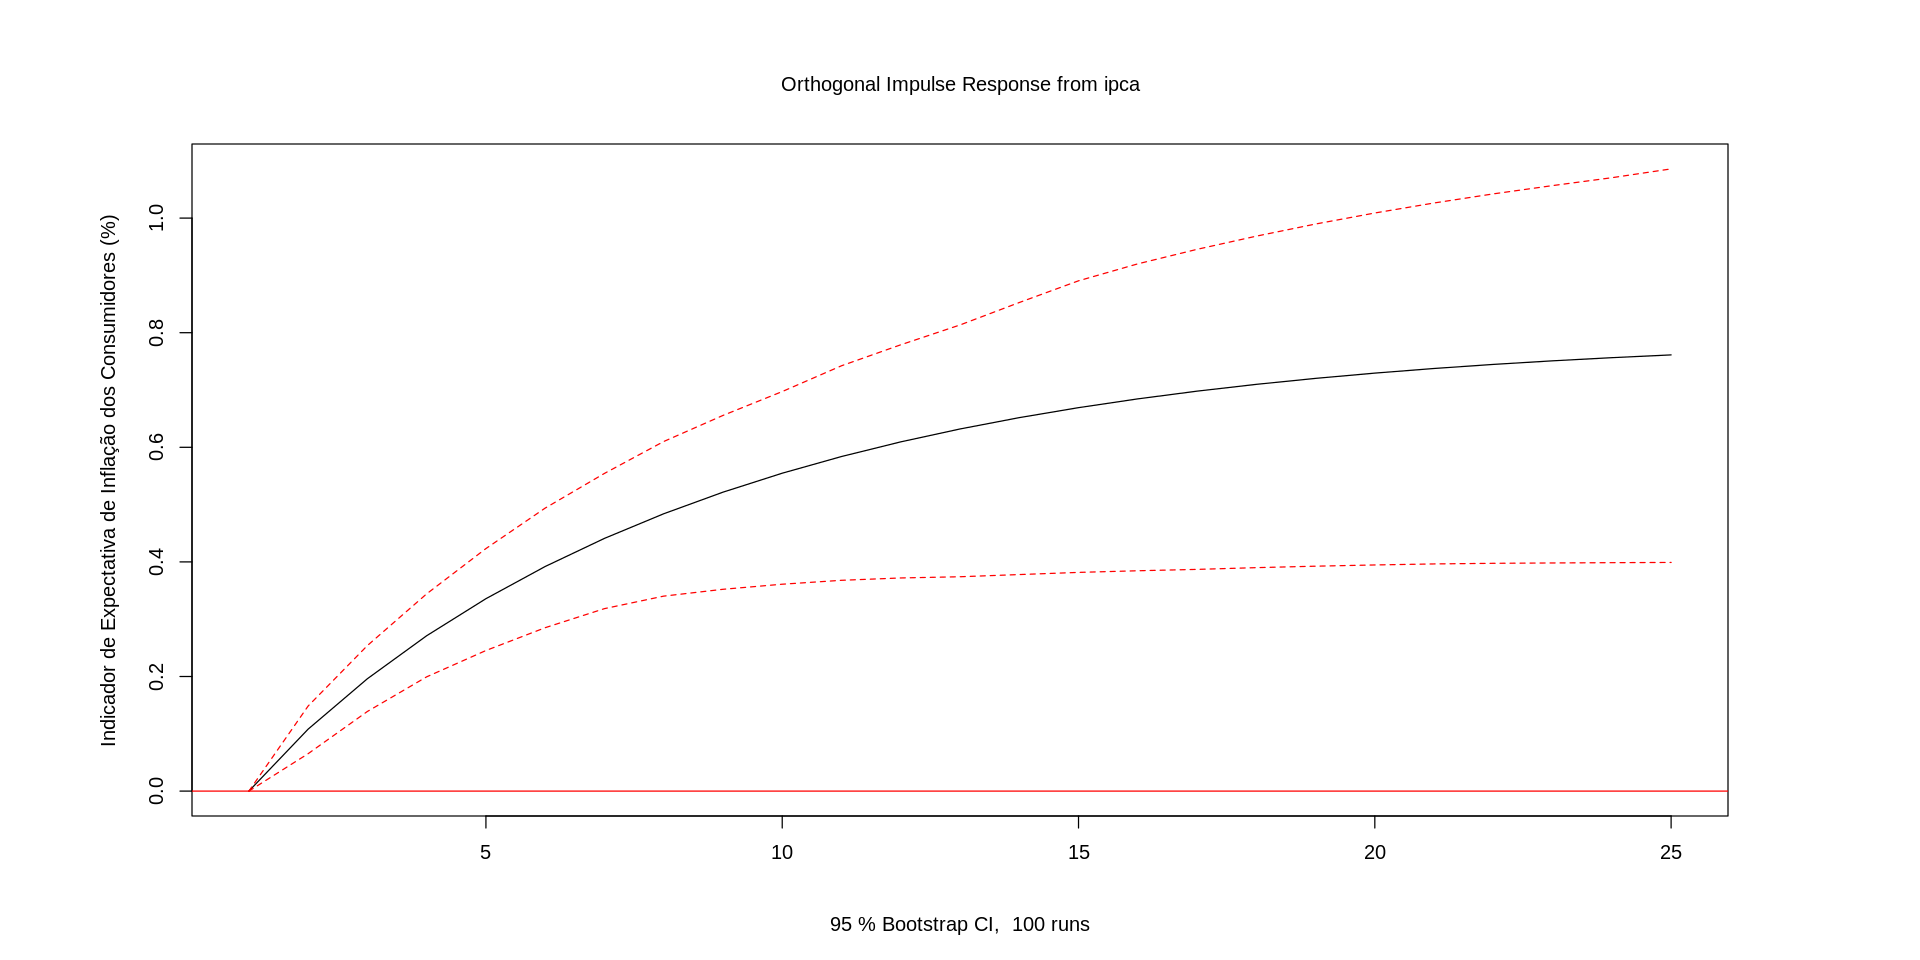

In [128]:
# Impulse Response Function
vecm_consumer_expectation_impulse = irf(vecm_model_formatted, impulse = "ipca", response = "consumer_inflation_expectation", n.ahead = 24, boot = TRUE)

plot(vecm_consumer_expectation_impulse, ylab = "Indicador de Expectativa de Inflação dos Consumidores (%)")

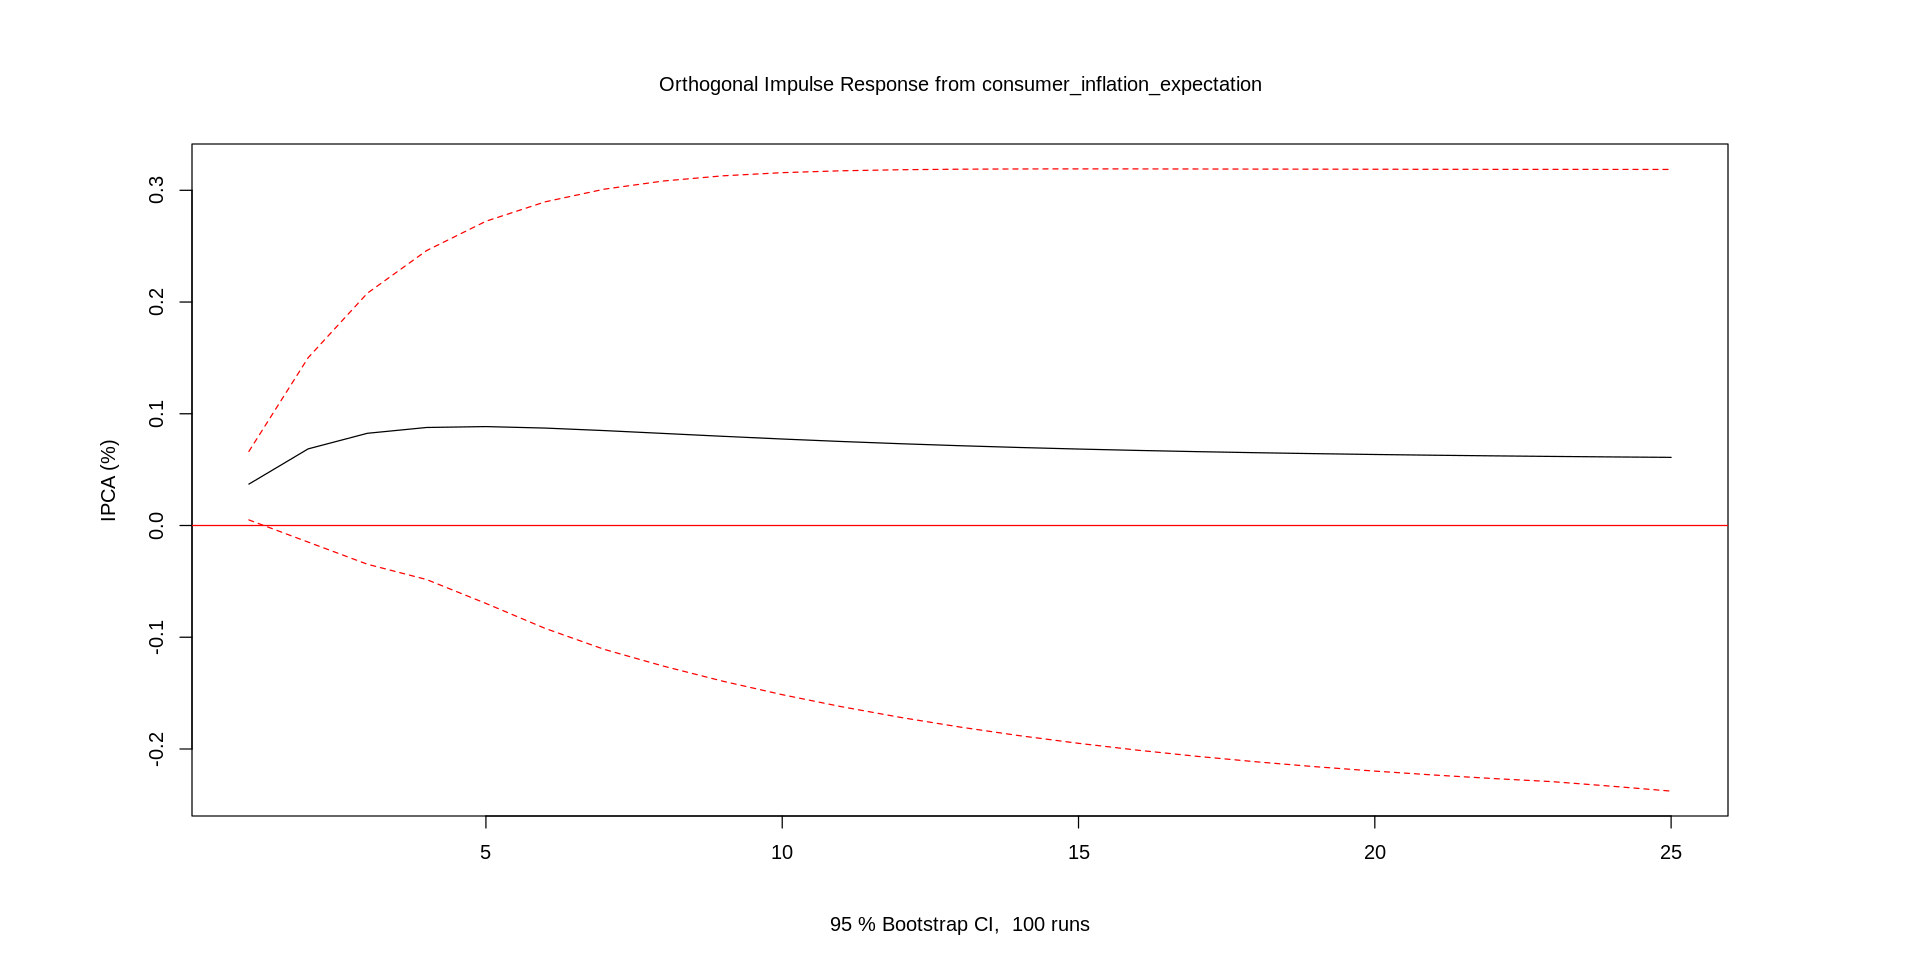

In [125]:
# Impulse Response Function
vecm_ipca_impulse = irf(vecm_model_formatted, impulse = "consumer_inflation_expectation", response = "ipca", n.ahead = 24, boot = TRUE)

plot(vecm_ipca_impulse, ylab = "IPCA (%)")

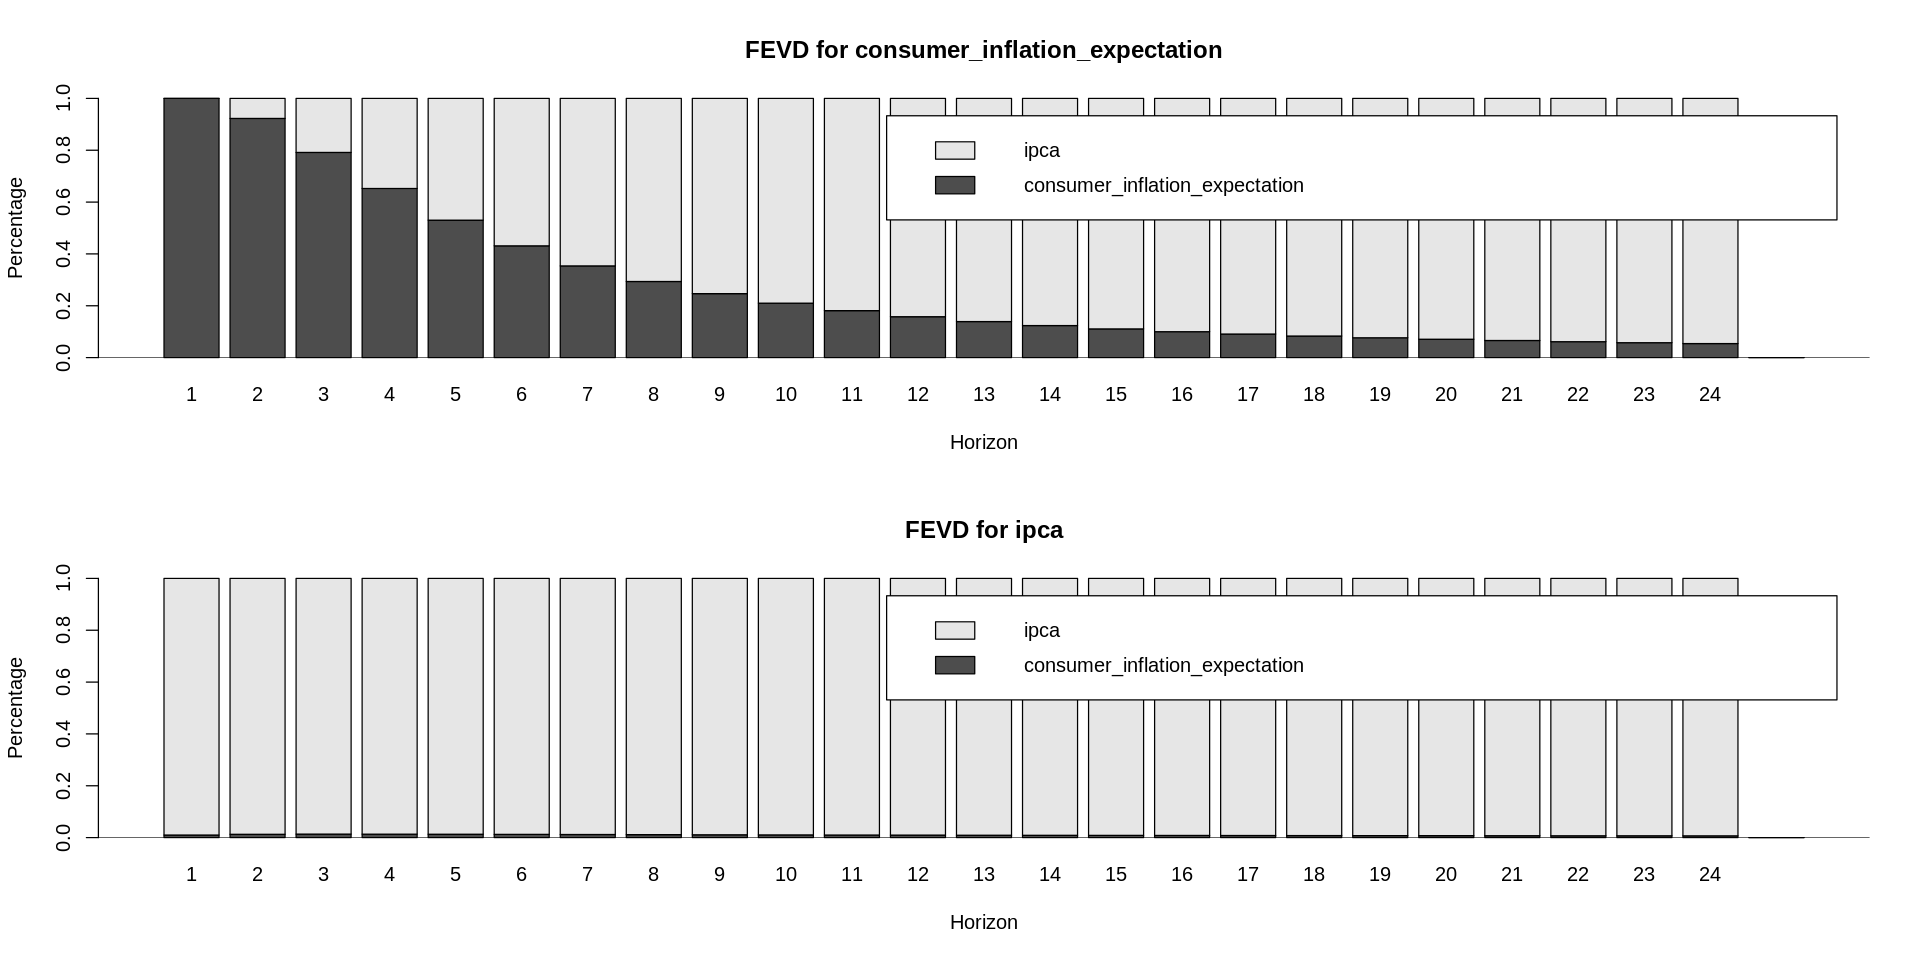

In [131]:
# Variance Decomposition
vecm_fevd <- fevd(vecm_model_formatted, n.ahead = 24)

plot(vecm_fevd)

**Resultado**

- Depois de ~6 meses, a expectativa de inflação é mais explicada pelo IPCA do que a própria variável expectativa de inflação

- A variável IPCA é, aproximadamente em sua totalidade, explicada pelo próprio IPCA

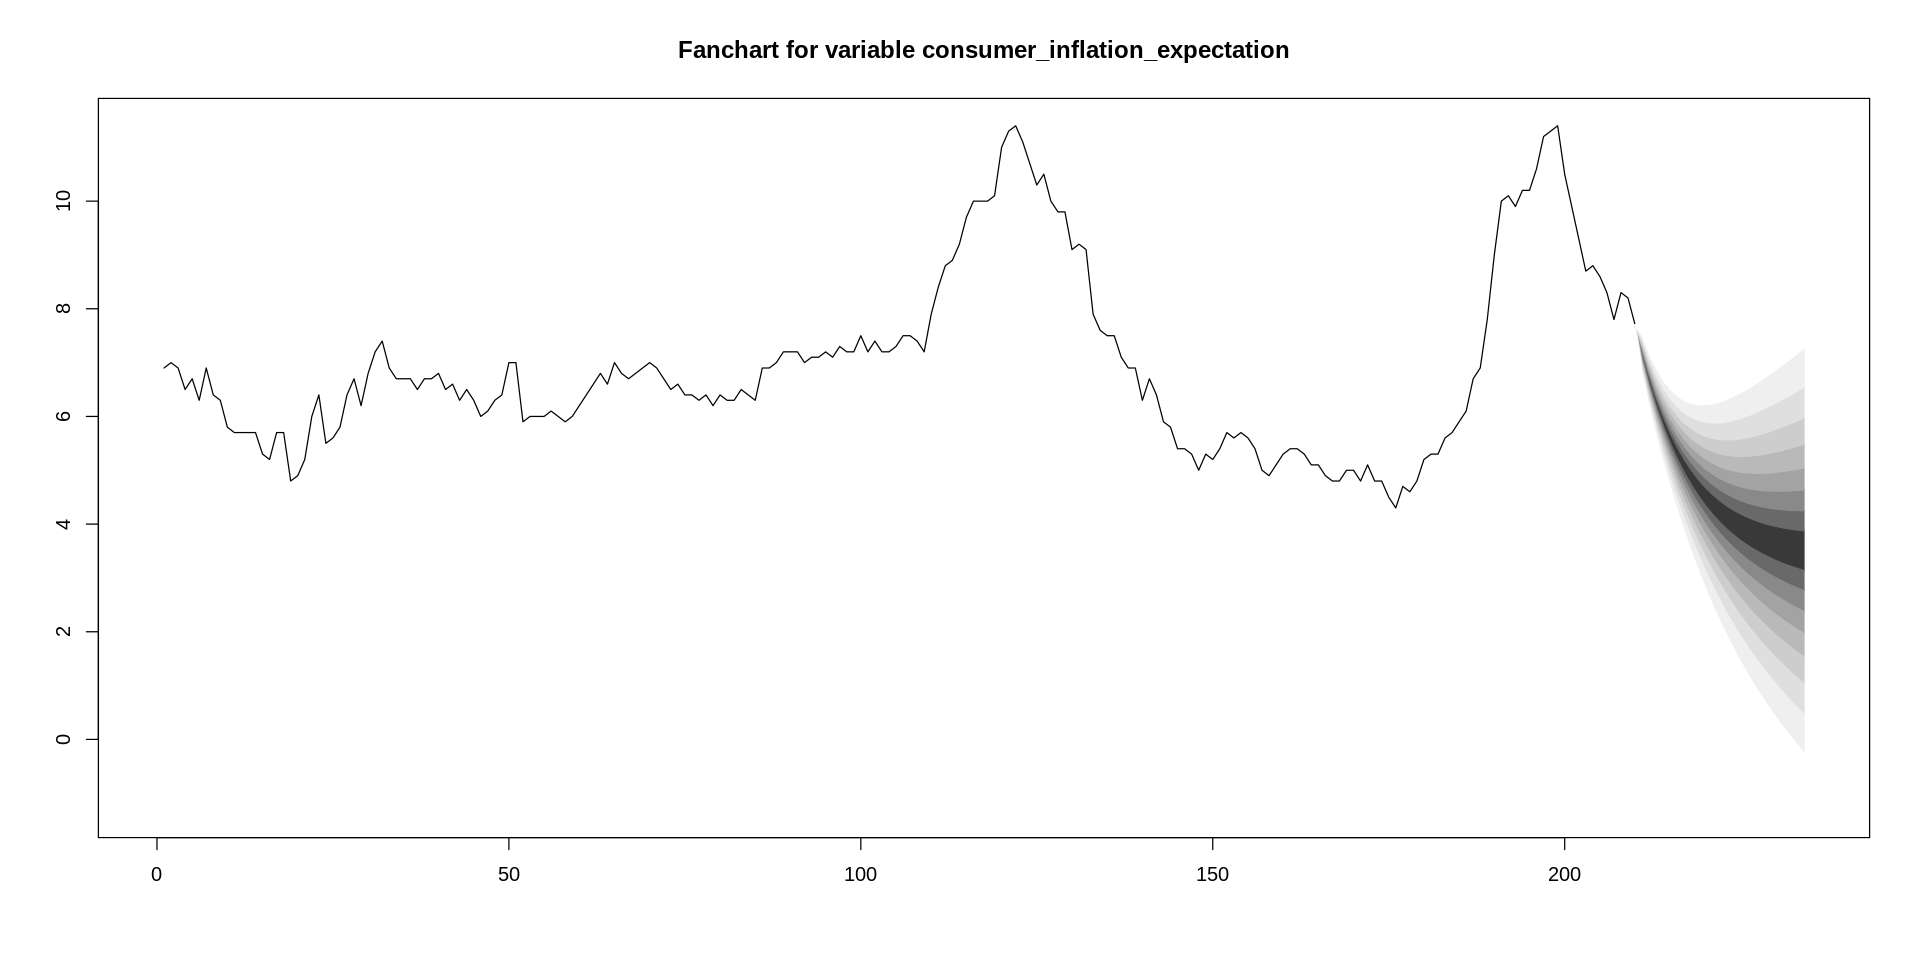

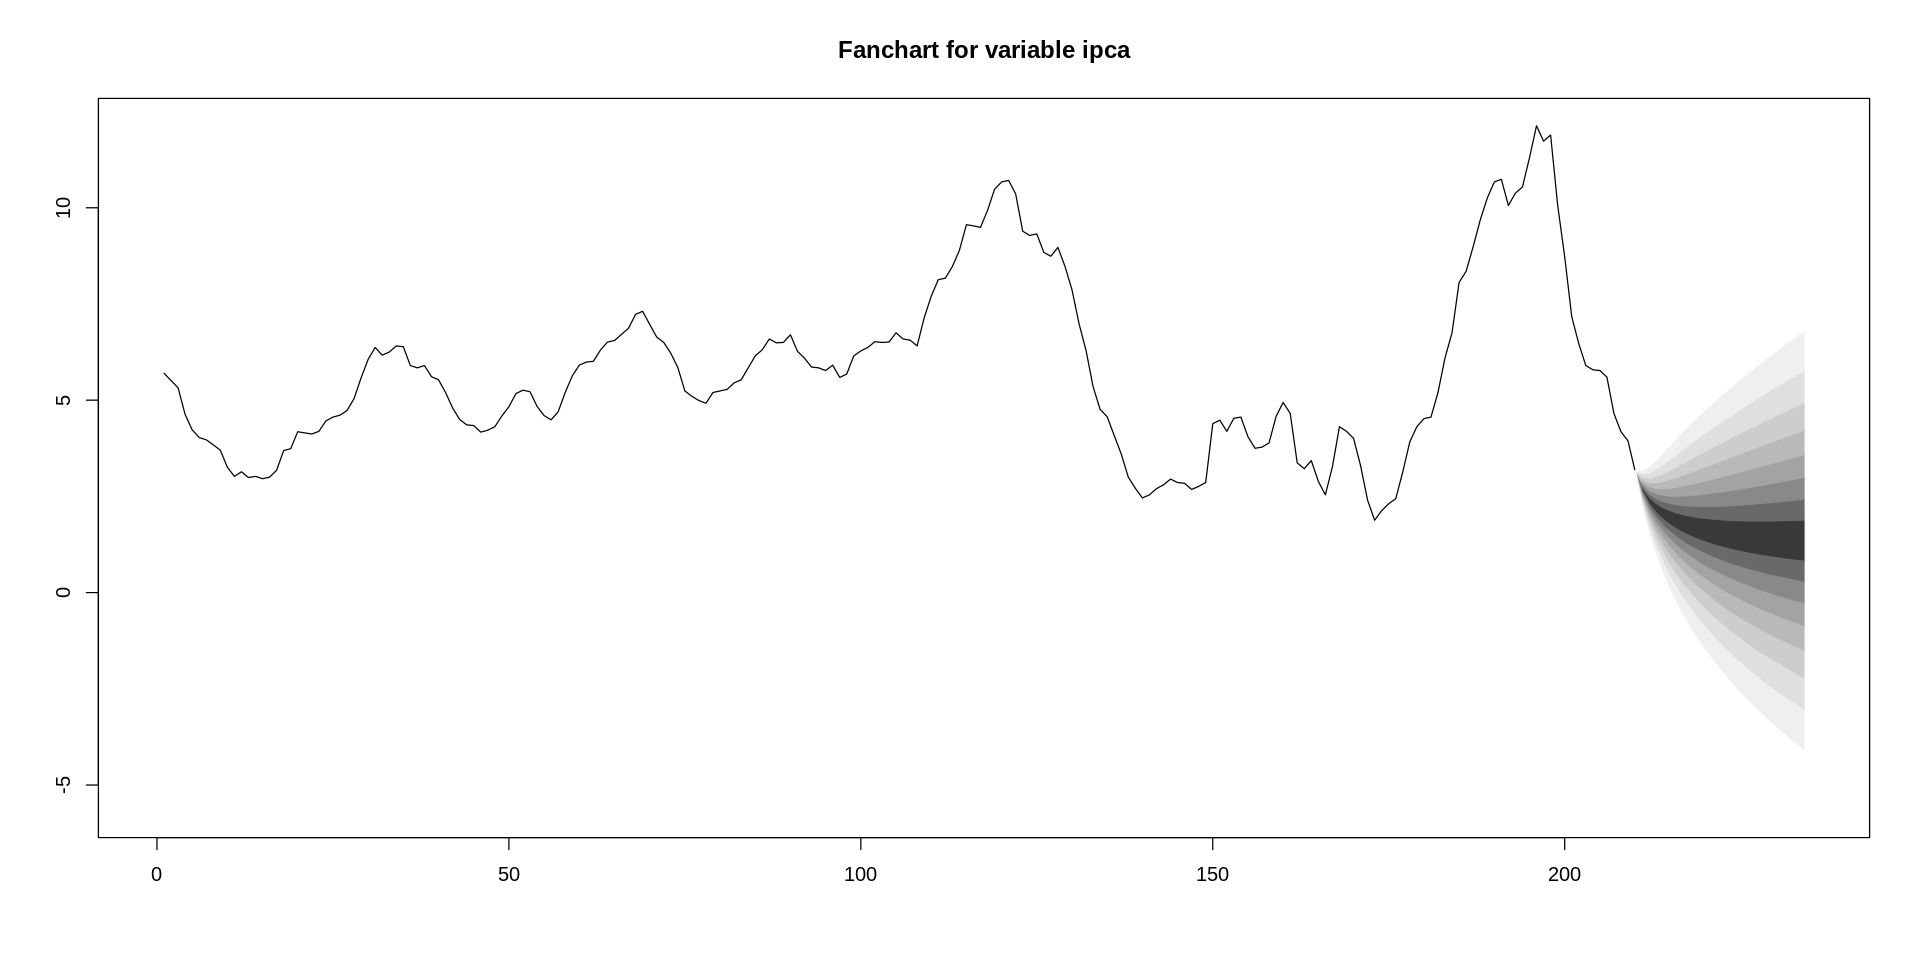

In [134]:
# Forecast using VECM
forecast_vecm <- predict(vecm_model_formatted, n.ahead = 24, ci = 0.95)

fanchart(forecast_vecm, names = "consumer_inflation_expectation")
fanchart(forecast_vecm, names = "ipca")